# Trabajo Práctico Final: Análisis completo de un conjunto de datos
Para la materia: Topicos avanzados en minería de datos - C2 2024

**Alumno:** [Joaquin Caporalini](mailto:joaquicaporalini@gmail.com)

**Docente:** [Pablo Granitto](mailto:granitto@cifasis-conicet.gov.ar)

## Los datos elegidos

Los datos para este trabajo fueron conseguidos a traves de la [cooperativa de servicios públicos, crédito y vivienda de Maria Teresa](http://fescoe.com.ar/cooperativas/cooperativa-de-maria-teresa-ltda/) quien pone a disposición de la comunidad los resultados de los análisis realizados al agua que se extrae desde el subsuelo para luego ser potabilizada y suministrada a los distintos hogares de la localidad.

Los datos se dividen en dos grandes grupos. El primero es la llegada de agua hasta la planta potabilizadora y un segundo grupo es los análisis al agua dentro de la red de agua ya potabilizada. En este trabajo me centraré en el primer grupo. 

El agua que llega para ser potabilizada es analizada por distintos laboratorios bajo las normativa vigente dentro de la provincia de Santa Fe *ley 11.220* y puede provenir de distintas perforaciones (no se poseen esas etiquetas) que vuelcan distintas calidades de agua lo que hacen variar los estudios de laboratorio.

Los datos se me entregaron de la siguiente forma:

![ejemploAnalisis.jpg](https://labdcc.fceia.unr.edu.ar/~jcaporalini/tmd/ejemploAn%c3%a1lisis.jpg)

Quedó a mi cargo tabular los datos para analizarlos.

La variables dentro de los parámetros físico-Químicos son:
+ **pH**: pH de la muestra analizada. (sin unidad)
+ **conductividad**: medida de la capacidad del agua para conducir corriente eléctrica. (uS/cm)
+ **nitratos**: medida en mg/l de la muestra.
+ **arsénico**: medida en mg/l de la muestra.
+ **floururos**: medida en mg/l de la muestra.
+ **sodio**: medida en mg/l de la muestra.
+ **hierro**: medida en mg/l de la muestra.
+ **manganeso**: medida en mg/l de la muestra.
+ **calificación**: (target) el agua aprueba las condiciones impuestas por la *ley 11.220* siendo apta para el consumo.

In [1]:
parametrosFisicosQuimicosAgua <- read.csv("AnalisisQuimicoAgua.csv")

In [2]:
library(randomForest)
library(kernlab)
library(MASS)


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



## Pre-tratamiento

Voy a comenzar la preparación de los datos para su posterior uso durante el trabajo.

Las etapas que voy a seguir son:
+ Ver los datos
+ Valores faltantes y duplicados
+ Conversión de formatos
+ Clases desbalanceadas 
+ Resumen de los datos

### Ver los datos

Los datos provistos por parte del personal van desde el 2018 hasta la actualidad y son solo las copias impresas. Se disponen de más datos, puesto que la ley anteriormente citada dispone más mediciones de las que aquí se muestran, pero no todas estaban impresas y no disponía de tiempo para recolectar esa información y completarla. Opte por buscar todas posibles para acercarme para mantener las clases balanceadas y acercarme los más posible a la regla de *rule of thumb*.

In [3]:
dimensiones <- dim(parametrosFisicosQuimicosAgua)

cat("Cantidad de filas: ", dimensiones[1], "\n")
cat("Cantidad de columnas: ", dimensiones[2], "\n")

Cantidad de filas:  69 
Cantidad de columnas:  9 


In [4]:
str(parametrosFisicosQuimicosAgua)

'data.frame':	69 obs. of  9 variables:
 $ pH           : num  7.41 7.61 7.99 7.52 7.42 7.59 8.25 8.25 7.73 7.73 ...
 $ conductividad: int  668 675 691 905 880 676 760 756 812 651 ...
 $ nitratos     : num  10 10 25 0 0 25 24 24 7 10 ...
 $ arsénico     : num  0.037 0.045 0.043 0.047 0.045 0.022 0.035 0.03 0.035 0.042 ...
 $ floururos    : num  1.24 1.03 0.78 0.47 0.52 0.42 0 0 0.39 0.65 ...
 $ sodio        : num  140 83 69 137 134 ...
 $ hierro       : num  0 0 0 0.002 0 0 0.001 0.001 0.001 0.001 ...
 $ manganeso    : num  0e+00 0e+00 0e+00 0e+00 0e+00 0e+00 1e-04 1e-03 1e-03 1e-03 ...
 $ calificación : chr  "Potable" "Potable" "Potable" "Potable" ...


In [5]:
head(parametrosFisicosQuimicosAgua)

,pH,conductividad,nitratos,arsénico,floururos,sodio,hierro,manganeso,calificación
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,7.41,668,10,0.037,1.24,139.84,0.000,0,Potable
2,7.61,675,10,0.045,1.03,83.02,0.000,0,Potable
3,7.99,691,25,0.043,0.78,69.00,0.000,0,Potable
4,7.52,905,0,0.047,0.47,136.80,0.002,0,Potable
5,7.42,880,0,0.045,0.52,133.80,0.000,0,Potable
6,7.59,676,25,0.022,0.42,85.94,0.000,0,Potable


### Valores faltantes y duplicados

Para los valores faltantes tomé varias decisiones. La primera es descartar todos los estudios parciales como el siguiente

![parcial](https://labdcc.fceia.unr.edu.ar/~jcaporalini/tmd/Laboratorio%20Parcial.jpg)

No se requiere que todo el tiempo todos los estudios y por eso había muchos incompletos de esa forma.

Otra decisión es completar `NSD` por 0.001 puesto que es el valor mínimo detectable por muchos de los laboratorios (existen algunos que son capaces de detectar 0).

![parcial](https://labdcc.fceia.unr.edu.ar/~jcaporalini/tmd/NulosYfaltantes.jpg)

In [6]:
as.data.frame(colSums(is.na(parametrosFisicosQuimicosAgua)))

,colSums(is.na(parametrosFisicosQuimicosAgua))
,<dbl>
pH,0
conductividad,0
nitratos,0
arsénico,0
floururos,0
sodio,0
hierro,0
manganeso,0
calificación,0


In [7]:
sum(duplicated(parametrosFisicosQuimicosAgua))

[1] 6

In [8]:
which(duplicated(parametrosFisicosQuimicosAgua))

[1] 53 54 55 57 58 64

`duplicated` verifica si el primer parámetro se repite, en este caso la medición del pH se repite en esos casos pero vienen de estudios distintos, no hay duplicados.

Estos análisis son útiles para validar mí carga de datos desde el papel hasta el csv con datos

### Clases desbalanceadas

Como mencioné anteriormente los datos fueron cargados a propósito de tal forma que queden lo más balanceados posible. Dentro de los estudios en papel los calificados como potables fueron la mayoría para seleccionar entre ellos tomé de manera más o menos homogénea en el tiempo y de forma aleatoria.

Me repito de vuelta: El personal mencionó la existencia de más datos pero por cuestiones de tiempo no pude seleccionar, catalogar y cargar más.

In [9]:
table(parametrosFisicosQuimicosAgua$calificación)


NoPotable   Potable 
       33        36 

### Conversión de formatos

Los datos son todos numéricos, lo único que voy a hacer es pasar a factor la variable asociada al si es potable o no

In [10]:
parametrosFisicosQuimicosAgua$`calificación` <- as.factor(parametrosFisicosQuimicosAgua$`calificación`)


In [11]:
variables <- which(!names(parametrosFisicosQuimicosAgua) == "calificación")

parametrosFisicosQuimicosAgua.x <- parametrosFisicosQuimicosAgua[,variables]
parametrosFisicosQuimicosAgua.y <- parametrosFisicosQuimicosAgua[,-variables]

head(parametrosFisicosQuimicosAgua.x)

,pH,conductividad,nitratos,arsénico,floururos,sodio,hierro,manganeso
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.41,668,10,0.037,1.24,139.84,0.000,0
2,7.61,675,10,0.045,1.03,83.02,0.000,0
3,7.99,691,25,0.043,0.78,69.00,0.000,0
4,7.52,905,0,0.047,0.47,136.80,0.002,0
5,7.42,880,0,0.045,0.52,133.80,0.000,0
6,7.59,676,25,0.022,0.42,85.94,0.000,0


In [12]:
summary(parametrosFisicosQuimicosAgua)

       pH        conductividad     nitratos        arsénico      
 Min.   :7.320   Min.   : 571   Min.   : 0.00   Min.   :0.01200  
 1st Qu.:7.630   1st Qu.: 669   1st Qu.: 7.00   1st Qu.:0.03100  
 Median :7.750   Median : 690   Median :10.00   Median :0.04400  
 Mean   :7.776   Mean   :1207   Mean   :13.07   Mean   :0.08086  
 3rd Qu.:7.900   3rd Qu.:1205   3rd Qu.:22.00   3rd Qu.:0.07500  
 Max.   :8.510   Max.   :4610   Max.   :25.00   Max.   :0.37000  
   floururos          sodio             hierro          manganeso       
 Min.   :0.0000   Min.   :  33.42   Min.   :0.00000   Min.   :0.000000  
 1st Qu.:0.5700   1st Qu.:  83.02   1st Qu.:0.00100   1st Qu.:0.001000  
 Median :0.7800   Median : 139.84   Median :0.00100   Median :0.001000  
 Mean   :0.9374   Mean   : 313.48   Mean   :0.00187   Mean   :0.000958  
 3rd Qu.:1.0800   3rd Qu.: 275.28   3rd Qu.:0.00100   3rd Qu.:0.001000  
 Max.   :3.3200   Max.   :2204.85   Max.   :0.03100   Max.   :0.006000  
    calificación
 NoPotable

## Visualizaciones

En esta sección me propongo ver algunos de los comentarios hechos desde los proveedores del servicio de agua. Primero se harán algunos análisis a traves de una única variable con respecto a nuestro target. Luego se harán análisis entre las distintas variables entre ellas en formato de scatterplot tanto de los datos como desde su PCA

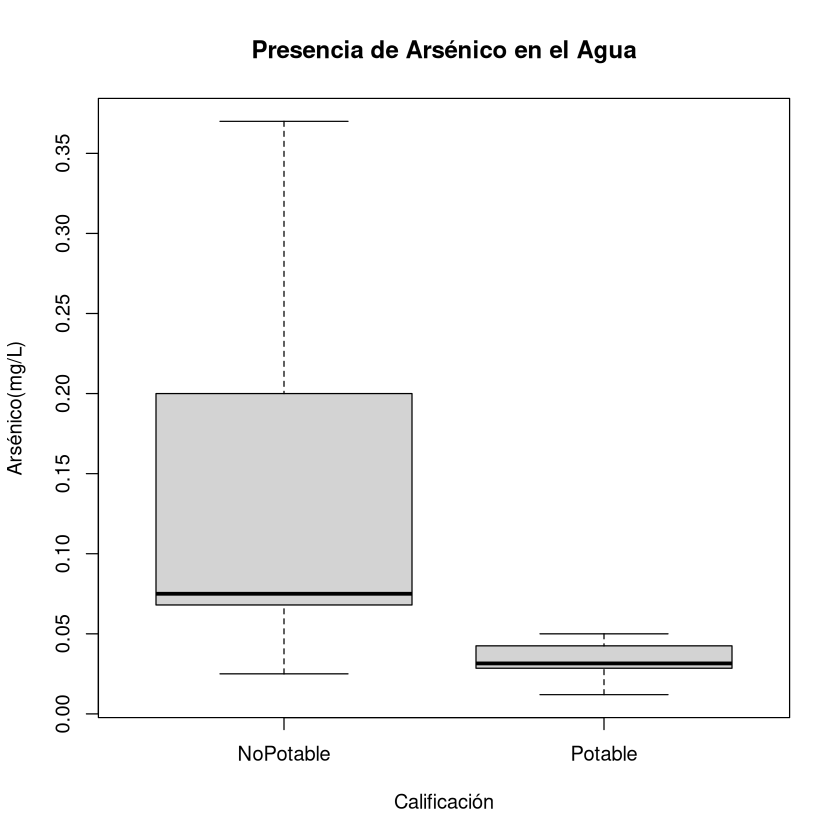

In [13]:
boxplot(arsénico ~ `calificación`, data = parametrosFisicosQuimicosAgua,main = "Presencia de Arsénico en el Agua", xlab = "Calificación", ylab = "Arsénico(mg/L)")

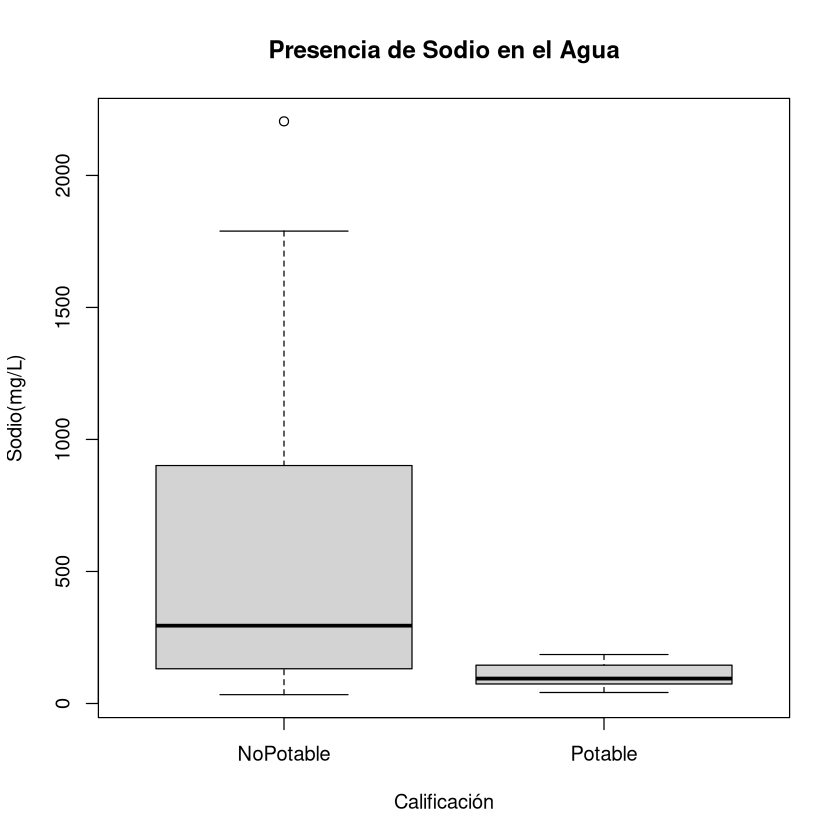

In [14]:
boxplot(sodio ~ `calificación`, data = parametrosFisicosQuimicosAgua,main = "Presencia de Sodio en el Agua", xlab = "Calificación", ylab = "Sodio(mg/L)")

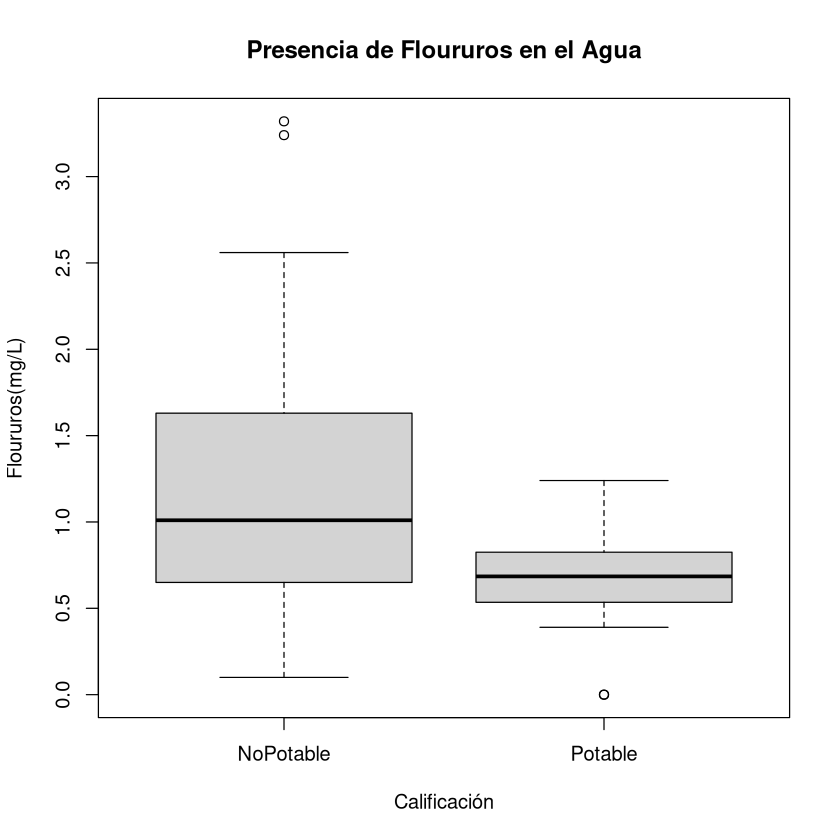

In [15]:
boxplot(floururos ~ `calificación`, data = parametrosFisicosQuimicosAgua,main = "Presencia de Floururos en el Agua", xlab = "Calificación", ylab = "Floururos(mg/L)")

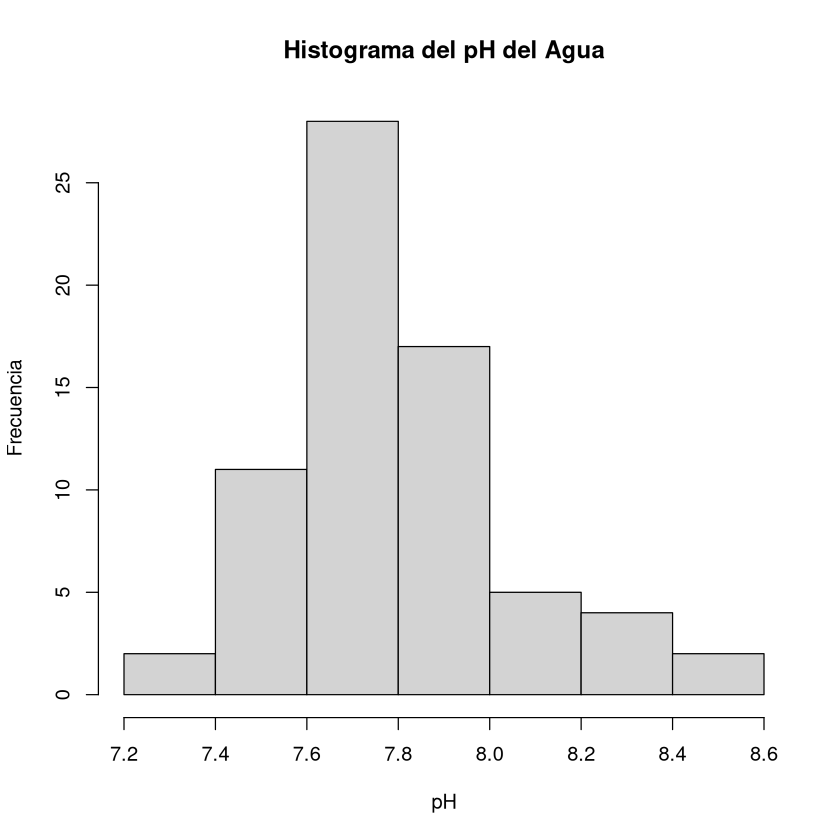

In [16]:
hist(parametrosFisicosQuimicosAgua$pH,main = "Histograma del pH del Agua", xlab = "pH", ylab = "Frecuencia")

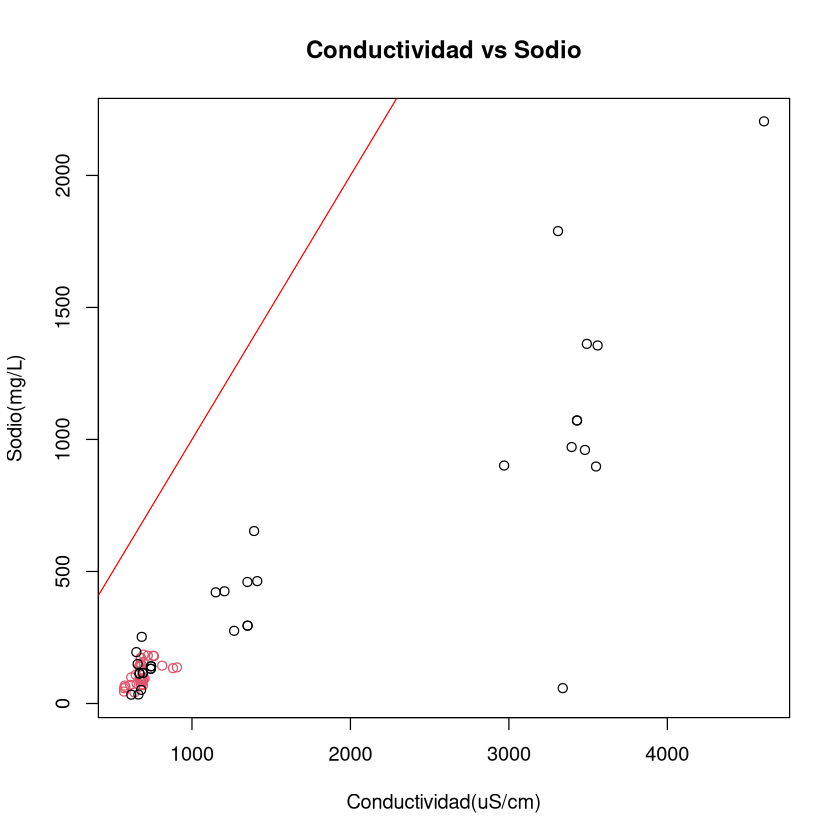

In [17]:
plot(x = parametrosFisicosQuimicosAgua$conductividad, y = parametrosFisicosQuimicosAgua$sodio, col = parametrosFisicosQuimicosAgua$`calificación`, main = "Conductividad vs Sodio", xlab = "Conductividad(uS/cm)", ylab = "Sodio(mg/L)")
curve((x), from=0, to = 5000, add = TRUE, col = "red") # Solo está para poder poner en perspectiva con el log

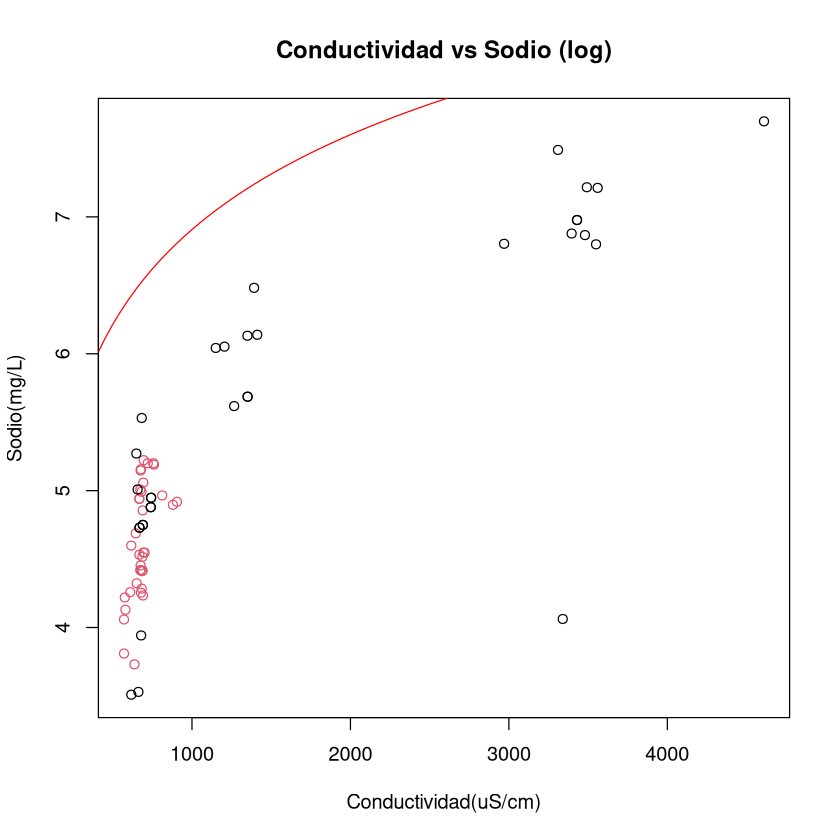

In [18]:
plot(x = parametrosFisicosQuimicosAgua$conductividad, y = log(parametrosFisicosQuimicosAgua$sodio), col = parametrosFisicosQuimicosAgua$`calificación`, main = "Conductividad vs Sodio (log)", xlab = "Conductividad(uS/cm)", ylab = "Sodio(mg/L)")
curve(log(x), from = 0, to = 5000, add = TRUE, col = "red")


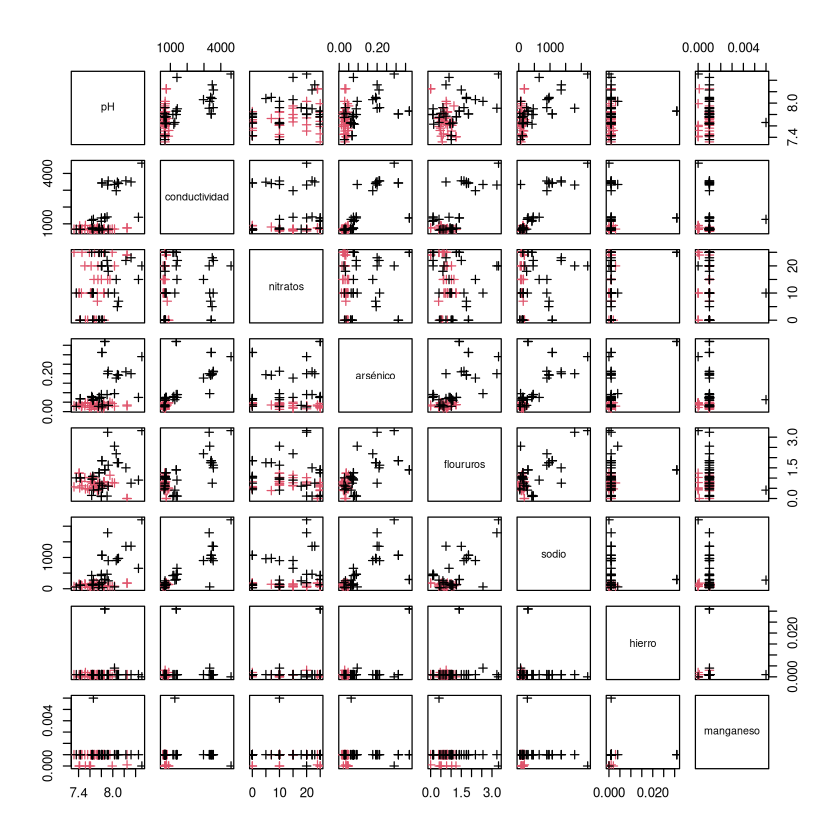

In [19]:
plot(parametrosFisicosQuimicosAgua.x, col = parametrosFisicosQuimicosAgua.y, pch = 3)

       pH        conductividad      nitratos          arsénico      
 Min.   :1.991   Min.   :6.347   Min.   :-6.9078   Min.   :-4.4228  
 1st Qu.:2.032   1st Qu.:6.506   1st Qu.: 1.9459   1st Qu.:-3.4738  
 Median :2.048   Median :6.537   Median : 2.3026   Median :-3.1236  
 Mean   :2.051   Mean   :6.861   Mean   : 0.5094   Mean   :-2.9059  
 3rd Qu.:2.067   3rd Qu.:7.094   3rd Qu.: 3.0910   3rd Qu.:-2.5903  
 Max.   :2.141   Max.   :8.436   Max.   : 3.2189   Max.   :-0.9943  
   floururos            sodio           hierro         manganeso     
 Min.   :-6.90775   Min.   :3.509   Min.   :-6.908   Min.   :-9.210  
 1st Qu.:-0.56212   1st Qu.:4.419   1st Qu.:-6.908   1st Qu.:-6.908  
 Median :-0.24846   Median :4.940   Median :-6.908   Median :-6.908  
 Mean   :-0.42891   Mean   :5.141   Mean   :-6.762   Mean   :-6.915  
 3rd Qu.: 0.07696   3rd Qu.:5.618   3rd Qu.:-6.908   3rd Qu.:-6.908  
 Max.   : 1.19996   Max.   :7.698   Max.   :-3.474   Max.   :-5.116  

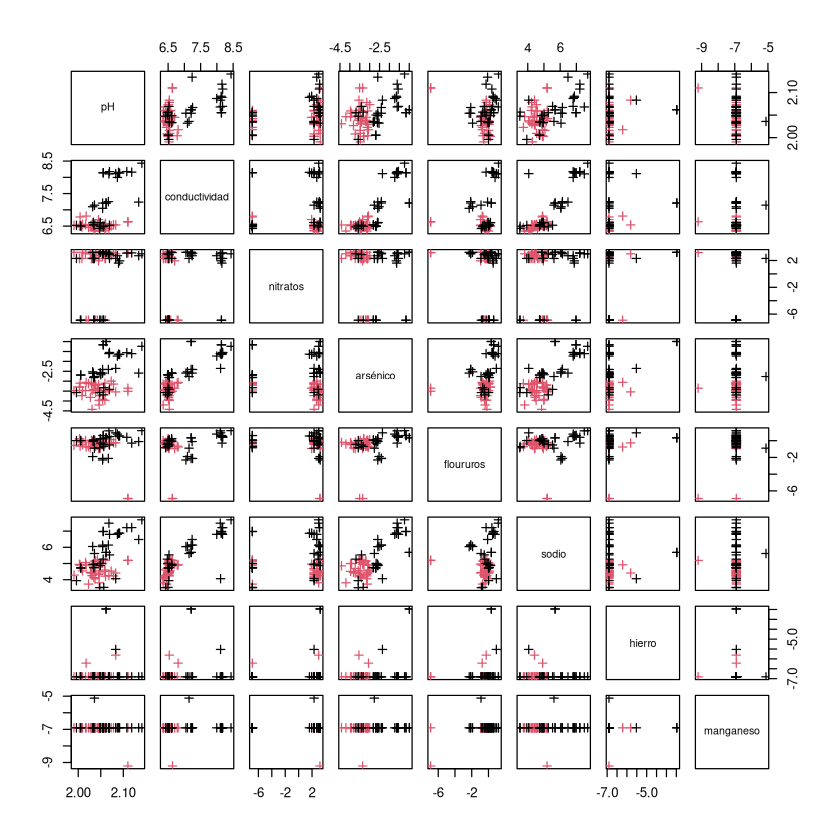

In [20]:

parametrosFisicosQuimicosAgua.log.x <- parametrosFisicosQuimicosAgua.x
parametrosFisicosQuimicosAgua.log.x$nitratos <- ifelse(parametrosFisicosQuimicosAgua.log.x$nitratos > 0, parametrosFisicosQuimicosAgua.log.x$nitratos, 0.001)
parametrosFisicosQuimicosAgua.log.x$floururos <- ifelse(parametrosFisicosQuimicosAgua.log.x$floururos > 0, parametrosFisicosQuimicosAgua.log.x$floururos, 0.001)
parametrosFisicosQuimicosAgua.log.x$hierro <- ifelse(parametrosFisicosQuimicosAgua.log.x$hierro > 0, parametrosFisicosQuimicosAgua.log.x$hierro, 0.001)
parametrosFisicosQuimicosAgua.log.x$manganeso <- ifelse(parametrosFisicosQuimicosAgua.log.x$manganeso > 0, parametrosFisicosQuimicosAgua.log.x$manganeso, 0.001)

parametrosFisicosQuimicosAgua.log.x <- log(parametrosFisicosQuimicosAgua.log.x)

summary(object = parametrosFisicosQuimicosAgua.log.x)

plot(parametrosFisicosQuimicosAgua.log.x, col = parametrosFisicosQuimicosAgua.y, pch = 3)

In [21]:
parametrosFisicosQuimicosAgua.x.scale <- scale(parametrosFisicosQuimicosAgua.x)
parametrosFisicosQuimicosAgua.pca <- prcomp(parametrosFisicosQuimicosAgua.x.scale)

parametrosFisicosQuimicosAgua.pca.x <- as.data.frame(parametrosFisicosQuimicosAgua.pca$x)

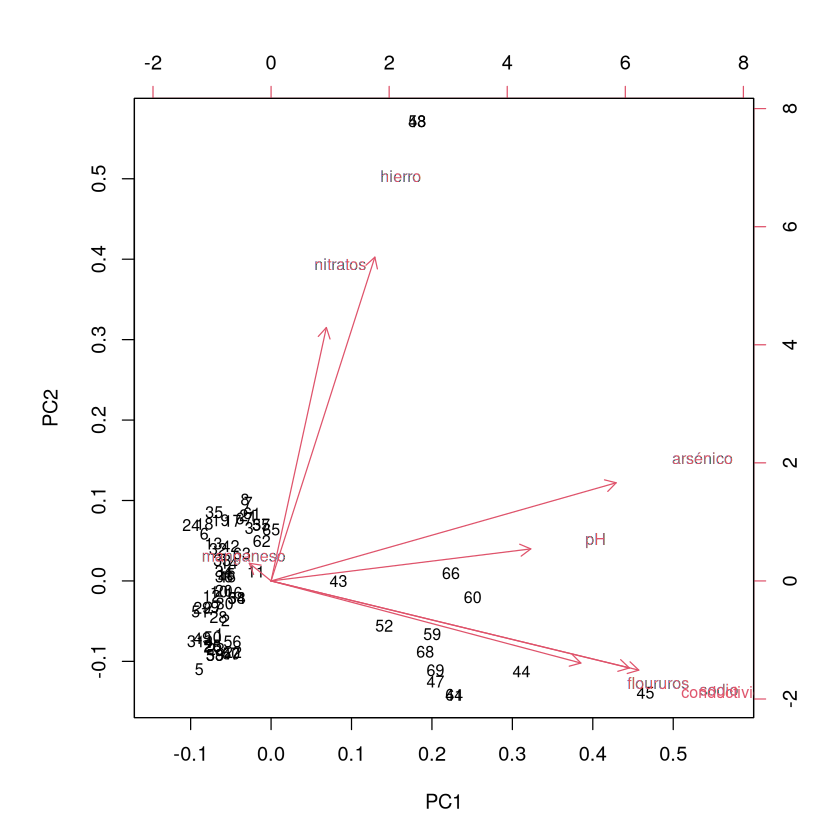

In [22]:
biplot(parametrosFisicosQuimicosAgua.pca,cex=0.8)

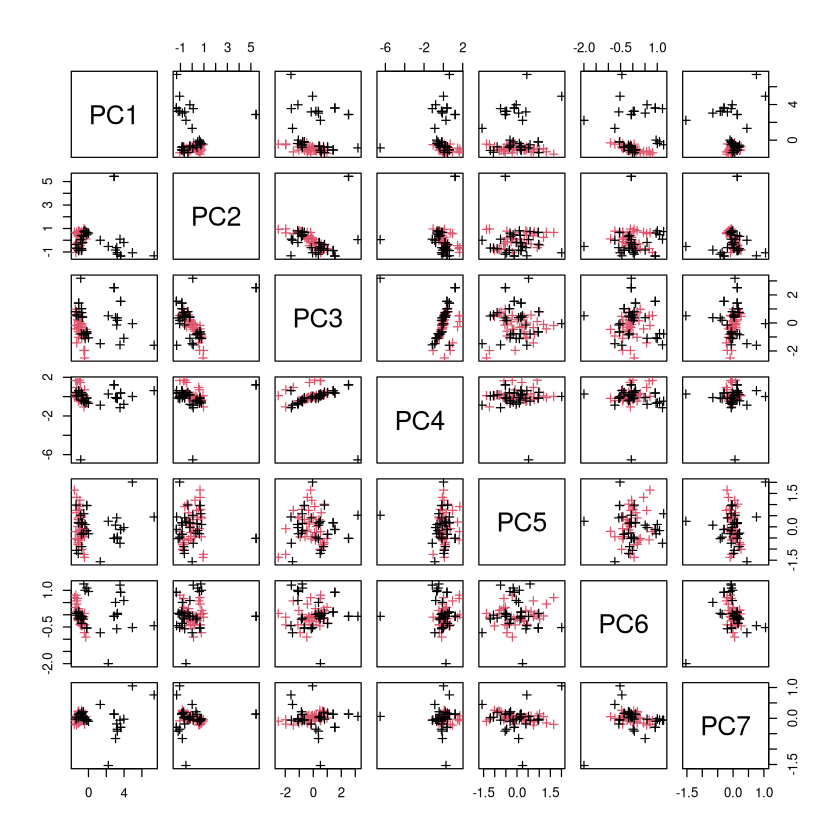

In [23]:
plot(parametrosFisicosQuimicosAgua.pca.x[,1:7], col = parametrosFisicosQuimicosAgua.y, pch = 3)

## Análisis de variables relevantes

In [24]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if (verbosity>1) cat("\n\n-> Forward Ranking Start...\n\tnum iterations: ", max.feat)
	if( verbosity>2) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>2) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>3) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n--------- Wrapper Greedy Forward ---------")
		cat("\n    ","Number of features: ", num.feat)
		cat("\n    ","Ranking: ", list.feat)
		cat("\n------------------------------------------\n")
	}

 	return(list.feat)

}


In [25]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#selection <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
backward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat <- dim(x)[2]		# total de features
	num.feat <- max.feat    # numero actual de features
	list.feat <- 1:max.feat # lista para guardar los features elegidos, inicializo como llegaron

	selection <- numeric(max.feat) # voy a generar acá el orden de las variables

	if (verbosity>1) cat("\n\n-> Backward Ranking Start...\n\tnum iterations: ", max.feat)

  # loop principal.
	# Voy a sacar variables hasta agotarlas
	while(1 < num.feat){

		# vector de error
		class.error<-double(num.feat)

		if (verbosity > 2) cat("\n---------\nStep ",max.feat - num.feat)
		# para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:num.feat){
		  features <- list.feat[-i]
			x.train <- as.matrix(x[,features, drop = FALSE])
			if (verbosity > 3) cat("\ntraning with: ", i, "...")
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}

		less.relevant.index <- which.min(class.error)
		selection[num.feat] <- list.feat[less.relevant.index]

		if(verbosity>2){
			cat("\nFeatures:\n",list.feat,"\nErrors:\n",class.error, "\nFeature less relevant ",less.relevant.index)
		}

		list.feat <- list.feat[-less.relevant.index]

		if(verbosity>2) cat("\nOutstanding features: ",list.feat, "\n")

		num.feat<-num.feat-1 #proximo paso
	}

	selection[1] <- list.feat[1]

	if(verbosity>1){
		cat("\n--------- Wrapper Greedy Backward --------")
		cat("\n    ","Number of features: ", max.feat)
		cat("\n    ","Ranking: ", selection)
		cat("\n------------------------------------------\n")
	}

 	return(selection)

}


In [26]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
kruskalwallis.ranking <- function(x,y,verbosity=0,... )
{

	max.feat <- dim(x)[2]		    # total de features
	list.feat <- 1:max.feat     # lista para guardar los features elegidos, inicializo como llegaron
  p.value <- double(max.feat) #

	if (verbosity>1) cat("\n-> kruskalwallis Start...\n\tnum iterations: ", max.feat)


	for (i in 1:max.feat){
    col <- x[,i];

    # Analiso con kruskal sobre ´col´
    kruskal.result <- kruskal.test(col,y);
    p.value[i] <- kruskal.result$p.value;

    if(verbosity>2) cat("Variable: ", i," p-value: ", p.value[i], "\n");
  }

  # ordeno de forma
  sorted <- order(p.value, decreasing = FALSE);

  list.feat <- list.feat[sorted]

  if(verbosity>1){
		cat("\n-------------- kruskalwallis -------------")
		cat("\n    ","Number of features: ", max.feat)
		cat("\n    ","Ranking: ", list.feat)
		cat("\n------------------------------------------\n")
	}

 	return(list.feat)

}


In [27]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#feat.ranking <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
rfe.ranking <- function(x,y,method,verbosity=0,... )
{

	feat.num <- dim(x)[2]		# cantidad de features

	feat.ranking <- numeric(feat.num) # Orden de las
	feat.keep    <- 1:feat.num        #

	selection <- numeric(feat.num) # voy a generar acá el orden de las variables

	if (verbosity>1) cat("\n\n-> RFE Start...\n\tnum iterations: ", feat.num)


  # loop principal.
	# Voy a sacar variables hasta agotarlas
	for (i in 1:feat.num){
    # Me quedo con las caracteristicas deseadas en formato de matriz
    x.train <- as.matrix(x[,feat.keep])

    # Calculo el ranking de las caracteristicas a partir de las que todavía no
    # usé
    rankings <- do.call(method, c(list(x.train, y), list(...)))

    # Me quedo con la peor de todas las caracteristicas
    less.relevant.index <- rankings$feats[1]

    feat.ranking[i] <- feat.keep[less.relevant.index]

    feat.keep <- feat.keep[-less.relevant.index]

    if(verbosity > 2){
	  	cat("Iteration ",i ," Column less relevant index: ", "\n")
	  }

  }

  feat.ranking <- rev(feat.ranking)


  if(verbosity>1){
		cat("\n------------------ RFE ------------------")
		cat("\n    ","Number of features: ", feat.num)
		cat("\n    ","Ranking: ", feat.ranking)
		cat("\n------------------------------------------\n")
	}

 	return(feat.ranking)

}


In [28]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


In [29]:
parametrosFisicosQuimicosAgua.FORW.rf <-  forward.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="rf.est", verbosity = 2)
parametrosFisicosQuimicosAgua.FORW.lda <- forward.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="lda.est", verbosity = 2)

parametrosFisicosQuimicosAgua.BACK.rf <-  backward.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="rf.est", tot.trees=100,equalize.classes=F, verbosity = 2)
parametrosFisicosQuimicosAgua.BACK.lda <- backward.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="lda.est", verbosity = 2)

parametrosFisicosQuimicosAgua.KRUS <-kruskalwallis.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y, verbosity = 2)

parametrosFisicosQuimicosAgua.RFE.rf     <-rfe.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="imp.rf", verbosity = 2)
parametrosFisicosQuimicosAgua.RFE.linsvm <-rfe.ranking(parametrosFisicosQuimicosAgua.x,parametrosFisicosQuimicosAgua.y,method="imp.linsvm", verbosity = 2)




-> Forward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Forward ---------
     Number of features:  8
     Ranking:  4 6 5 7 1 8 2 3
------------------------------------------


-> Forward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Forward ---------
     Number of features:  8
     Ranking:  2 8 6 7 1 4 3 5
------------------------------------------


-> Backward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Backward --------
     Number of features:  8
     Ranking:  4 8 6 7 1 5 3 2
------------------------------------------


-> Backward Ranking Start...
	num iterations:  8
--------- Wrapper Greedy Backward --------
     Number of features:  8
     Ranking:  6 7 8 1 4 3 2 5
------------------------------------------

-> kruskalwallis Start...
	num iterations:  8
-------------- kruskalwallis -------------
     Number of features:  8
     Ranking:  4 2 6 5 1 8 7 3
------------------------------------------


-> RFE Start...
	num ite

Muchos de los métodos siguen con lo expresado por quien entregó los datos. El agua extraída es un agua *dura* lo que implica una alta concentración de **arsénico**(4), **sodio**(5) y **fluor**(6), elementos que deben ser eliminados durante el proceso de potabilización puesto que estos elementos hacen que el agua sea no apta para consumo humano.

## Búsqueda de clustes

In [30]:
which.last.max <- function(xs) {
    return(length(xs) + 1 - which.max(rev(xs)))
}

In [31]:
# Input:
#       x: Matriz de datos
#       kMax: Máximo número de clusters a probar
#       b: Número de datos aleatorios a generar
#       nStart: Número de veces que se ejecutará kmeans
#       plotBool: Booleano para mostrar la gráfica (SOLO INFORMATIVO)
# Output:
#       k.optimal: Número de clusters óptimo
gap_statistic <- function(x, kMax = 15, b=15, nStart=15, plotBool=FALSE){
    # Inicializar una lista GAP[] para almacenar los valores GAP k
    gap.list <- double(kMax)
    # Inicializar una lista sd[] para almacenar desvío estandar k
    sd.list  <- double(kMax)
    # Inicializar una lista Wk[] para almacenar la medida de disperción k
    w_k.list <- numeric(kMax)

    # Calcular el rango de cada columna
    # es útil para samplear los datos de luego ya que tendremos en 
    # - [1,] mínimos
    # - [2,] máximos
    x.range <- apply(x, 2, range)

    for (k in 1:kMax) {
        # Calcular el GAP para el valor de k actual con los datos
        w_k         <- kmeans(x, centers = k, nstart = nStart)$tot.withinss
        w_k.list[k] <- w_k
        w_kb        <- double(b)

        

        for (j in 1:b) {
            # Generar datos aleatorios
            x_rand <- matrix(runif(nrow(x) * ncol(x), min=x.range[1,], max=x.range[2,]), ncol=ncol(x))
            # Calcular el GAP para el valor de k actual con los datos aleatorios (Es un dato en ´tot.withinss´)
            w_kb[j] <- kmeans(x_rand, centers = k, nstart = nStart)$tot.withinss
        }

        # Calcular el GAP para el valor de k actual
        gap.list[k] <- (1/b) * sum(log(w_kb) - log(w_k))

        # Calculo el desvió estandar para k
        l <- (1/b) * sum(log(w_kb))

        sd_k <- sqrt((1/b) * sum((log(w_kb) - l)^2))

        sd.list[k] <- sd_k * sqrt(1 + 1/b)
    }

    # Si el kMax es mayor a 1 y no hay un único cluster
    if (length(gap.list) > 1 && !(gap.list[2] + sd.list[2] <= gap.list[1])){
        k.optimal <- 2
        for (k in 2:(kMax-1)) {
            if (gap.list[k+1] - sd.list[k+1] <= gap.list[k]) {
                k.optimal <- k
                break
            }
        }
    } else 
       k.optimal <- 1 # único cluster

    if (plotBool){
        step <- 1:kMax
        plot(step, gap.list, type = "b", xlab="k", ylab="GAP(k)", main="GAP(k) vs k")
        abline(v=k.optimal, col="red")
    }
    return(k.optimal)
}

In [32]:
# Input:
#        n: número de puntos de los datos completos
#        ind1: índices de los puntos seleccionados en el primer clustering
#        ind2: índices de los puntos seleccionados en el segundo clustering
#        cc1: etiquetas de los clusters en el primer clustering
#        cc2: etiquetas de los clusters en el segundo clustering
# Output:
#        score: score de estabilidad
score_estabilidad <- function(n, ind1, ind2, cc1, cc2){ 

    v1 <- v2 <- rep(0,n)
    # La suma de 5 a cada etiqueta garantiza que los valores de los clusters se distingan de los ceros iniciales
    v1[ind1] <- cc1 + 5
    v2[ind2] <- cc2 + 5
    
    # Cálculo de matrices de coincidencia de clusters
    # m1 y m2 que indican la coincidencia de clusters para cada par de puntos en los dos agrupamientos 
    # tienen una pinta de la forma:
    # - 1 si los puntos están en el mismo cluster
    # - -1 si los puntos están en clusters diferentes
    # - 0 si alguno de los puntos no fue seleccionado en el clustering.


    # La raíz cuadrada de la multiplicación v1 %*% t(v1) permite verificar si dos puntos pertenecen al 
    # mismo cluster o no (ya que el resultado solo será un número entero si ambos están en el mismo cluster).
    a  <- sqrt(v1%*%t(v1))
    m1 <- a / -a + 2*(a==round(a))
    m1[is.nan(m1)] <- 0 # Elimino los NaN

    a  <- sqrt(v2%*%t(v2))
    m2 <- a / -a + 2*(a==round(a))
    m2[is.nan(m2)] <- 0
    
    #calculo el score, los pares de puntos que están en la misma situación en los dos clustering dividido el total de pares validos.
    validos <- sum(v1*v2>0)
    score   <- sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
    return(score)
}

# Input:
#        x: Matriz de datos
#        kMax: Máximo número de clusters a probar
#        nStart: Número de veces que se ejecutará kmeans
#        funcionEstabilidad: Función de estabilidad a utilizar
#        subSample: Porcentaje de datos a samplear
#        b: Número de veces que se repite el experimento
# Output:
#        score.max.index: Número de clusters óptimo

estabilidad <- function(x, kMax = 15, nStart=15, funcionEstabilidad=score_estabilidad, subSample=0.8, b=15, plotBool=FALSE) {
    filas <- dim(x)[1]
    
    score.list <- numeric(kMax)
    score.list[1] <- -1 # no debería ser 1 cluster?

    for (k in 2:kMax) {

        media <- numeric(b)

        for (i in 1:b) {
            # Creo dos indices al azar y hago los clusters
            ind1 <- sample(filas, subSample*filas)
            cc1  <- kmeans(x[ind1,], k, nstart=nStart)$cluster
            ind2 <- sample(filas, subSample*filas)
            cc2  <- kmeans(x[ind2,], k, nstart=nStart)$cluster
            media[i] <- funcionEstabilidad(filas, ind1, ind2, cc1, cc2)
        }

        score.list[k] <- mean(media)
    }

    # Tomamos la poción con el mayor score ó sorpresa la posición es el k (cant clusters)
    score.max.index <- which.last.max(score.list)

    if (plotBool){
        step <- 2:kMax
        plot(step, score.list[-1], type = "b", xlab="k", ylab="Score", main="Score vs k")
        abline(v=score.max.index, col="red")
    }

    return(score.max.index)
}


Buscamos cuales deberían ser los clusters óptimos para los datos
-> GAP statistic:  3

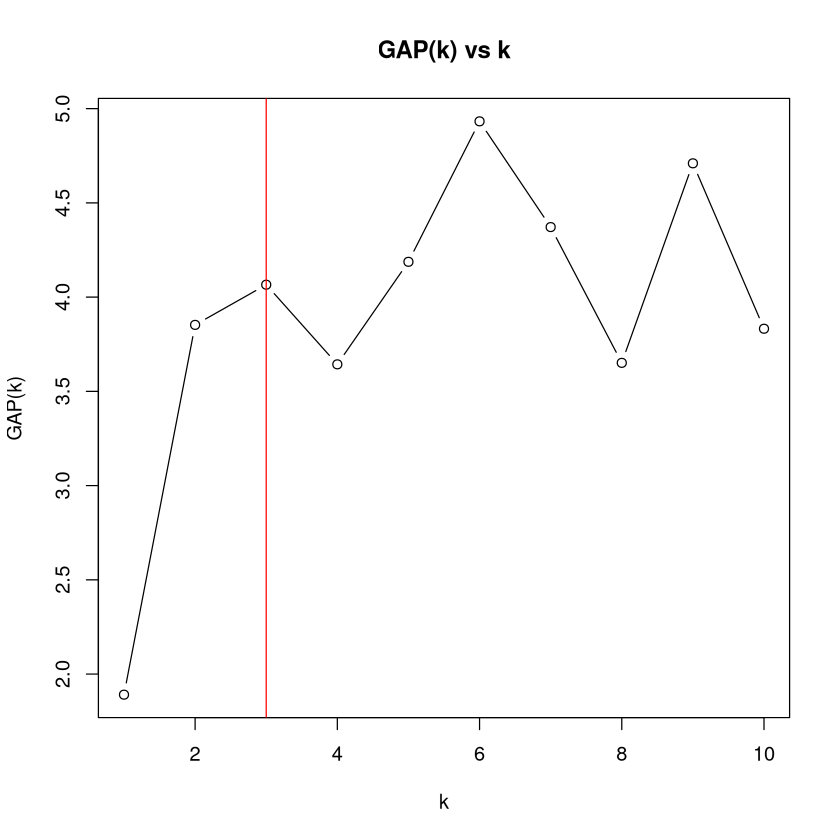


-> Estabilidad  :  2
Buscamos cuales deberían ser los clusters óptimos para los datos

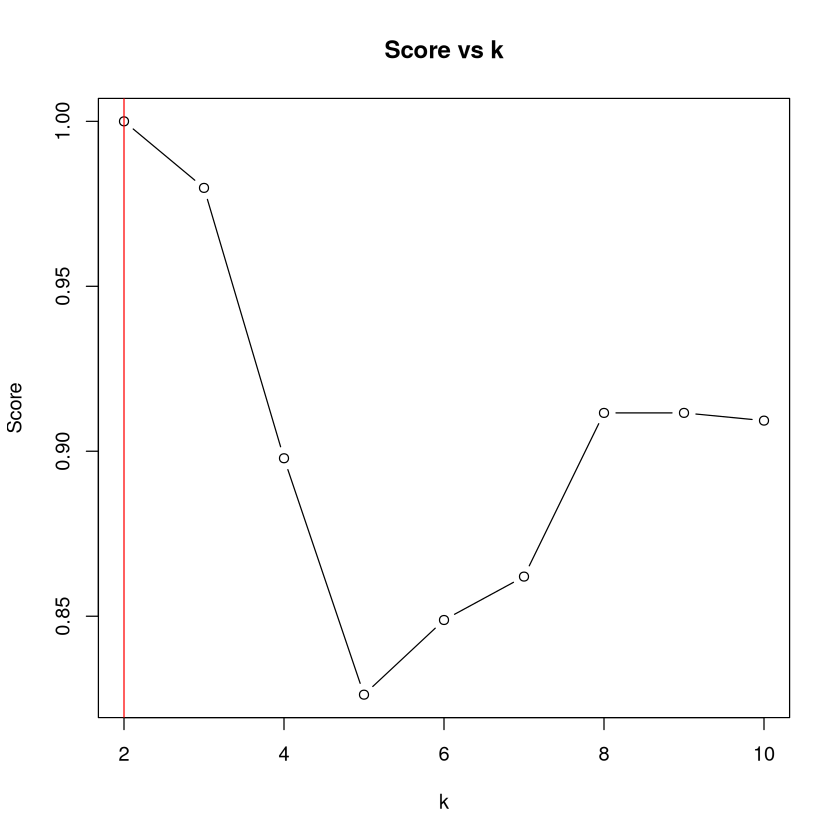


-> GAP statistic:  7

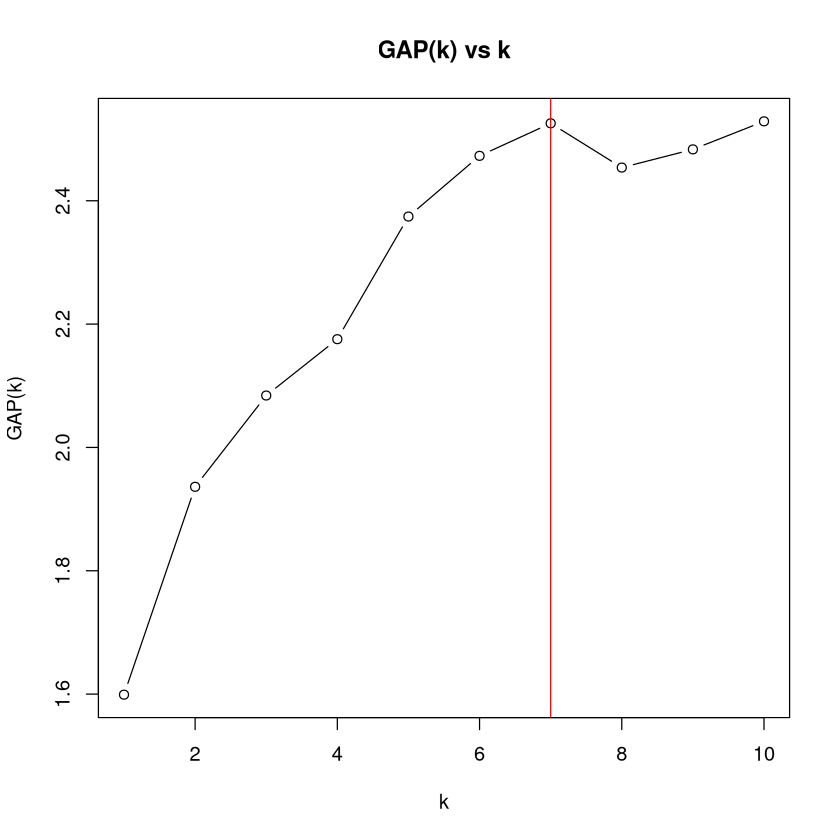


-> Estabilidad  :  2

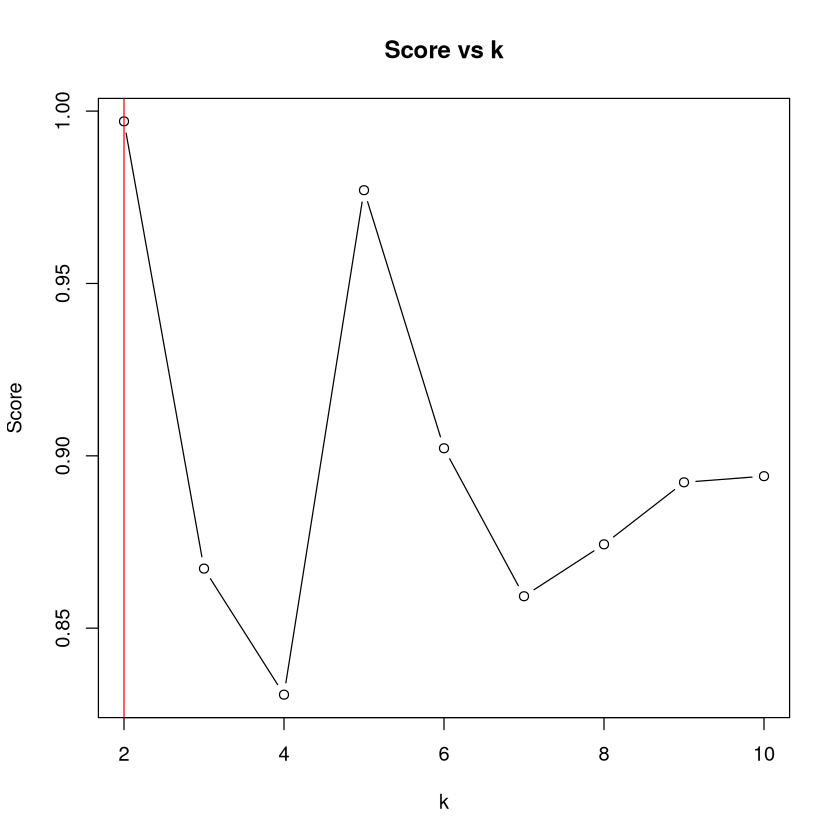

In [33]:
cat("\nBuscamos cuales deberían ser los clusters óptimos para los datos")
cat("\n-> GAP statistic: ", gap_statistic(parametrosFisicosQuimicosAgua.x, plotBool = TRUE, kMax = 10))
cat("\n-> Estabilidad  : ",   estabilidad(parametrosFisicosQuimicosAgua.x, plotBool = TRUE, kMax = 10))

cat("\nBuscamos cuales deberían ser los clusters óptimos para los datos")
cat("\n-> GAP statistic: ", gap_statistic(parametrosFisicosQuimicosAgua.pca.x, plotBool = TRUE, kMax = 10))
cat("\n-> Estabilidad  : ",   estabilidad(parametrosFisicosQuimicosAgua.pca.x, plotBool = TRUE, kMax = 10))

In [34]:
library(e1071)

compararClases <- function(agrupacion1, agrupacion2){
    # Crear una tabla de confución de las dos clasificaciones
    cont.table <- table(agrupacion1, agrupacion2)
    # Encontrar la coincidencia óptima entre las dos clasificaciones
    class.match <- matchClasses(as.matrix(cont.table),method="exact")
    # Imprimir la tabla de confusión, con filas permutadas para maximizar la diagonal
    print(cont.table[,class.match])
}

In [35]:
parametrosFisicosQuimicosAgua.kmeans.2 <- kmeans(parametrosFisicosQuimicosAgua.x, centers=2)
compararClases(parametrosFisicosQuimicosAgua.y, parametrosFisicosQuimicosAgua.kmeans.2$cluster)

parametrosFisicosQuimicosAgua.pca.kmeans.2 <- kmeans(parametrosFisicosQuimicosAgua.pca.x, centers=2)
compararClases(parametrosFisicosQuimicosAgua.y, parametrosFisicosQuimicosAgua.pca.kmeans.2$cluster)


parametrosFisicosQuimicosAgua.log.kmeans.2 <- kmeans(parametrosFisicosQuimicosAgua.log.x, centers=2)
compararClases(parametrosFisicosQuimicosAgua.y, parametrosFisicosQuimicosAgua.log.kmeans.2$cluster)

Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 68.12 %
           agrupacion2
agrupacion1  2  1
  NoPotable 11 22
  Potable    0 36
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 71.01 %
           agrupacion2
agrupacion1  1  2
  NoPotable 13 20
  Potable    0 36
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 55.07 %
           agrupacion2
agrupacion1  2  1
  NoPotable  9 24
  Potable    7 29


In [36]:
calcular_hclust <- function(x, methodUse = "compleat"){

    parametrosFisicosQuimicosAgua.dist  <- dist(x)
    parametrosFisicosQuimicosAgua.hclust <- hclust(parametrosFisicosQuimicosAgua.dist, method = methodUse)

    plot(as.dendrogram(parametrosFisicosQuimicosAgua.hclust))

    parametrosFisicosQuimicosAgua.hclust.cut.2 <- cutree(parametrosFisicosQuimicosAgua.hclust, k = 2)

    cat("\nMostrando los clustes\n")
    compararClases(parametrosFisicosQuimicosAgua.y,  parametrosFisicosQuimicosAgua.hclust.cut.2)
   
    # Mostralas a todas no tiene mucho sentido, pero si algunas
    # mustro las primeras 5 columnas (las primeras son interesantes luego de la PCA)
    plot(x[,1:5], col=parametrosFisicosQuimicosAgua.y,  pch=parametrosFisicosQuimicosAgua.hclust.cut.2, main="Clasificación hclust (2 clusters sp)")
}


Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 68.12 %
           agrupacion2
agrupacion1  2  1
  NoPotable 11 22
  Potable    0 36


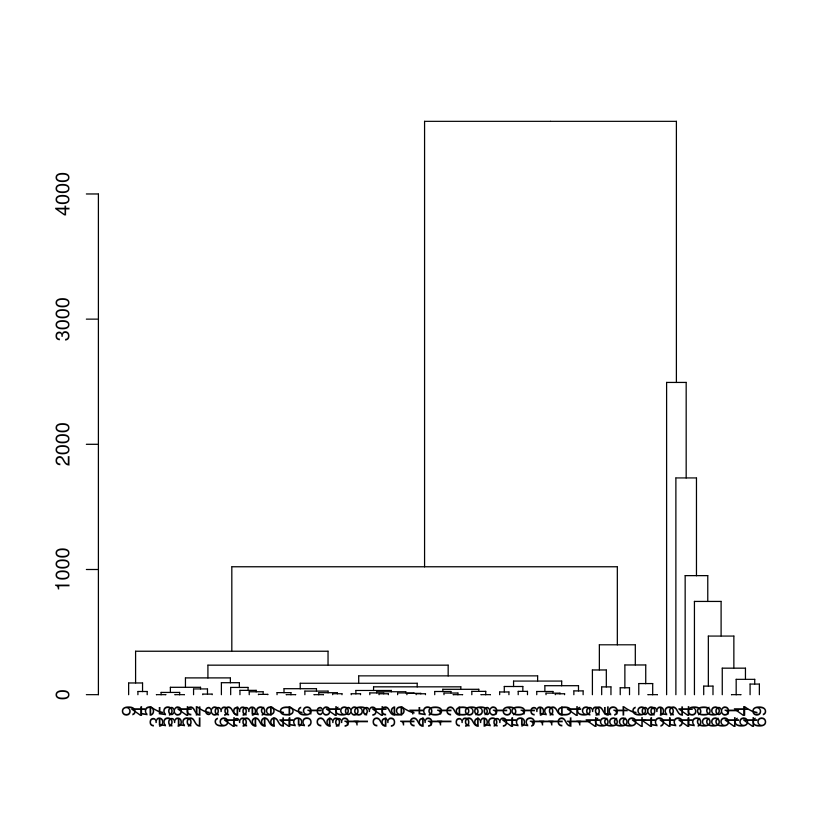

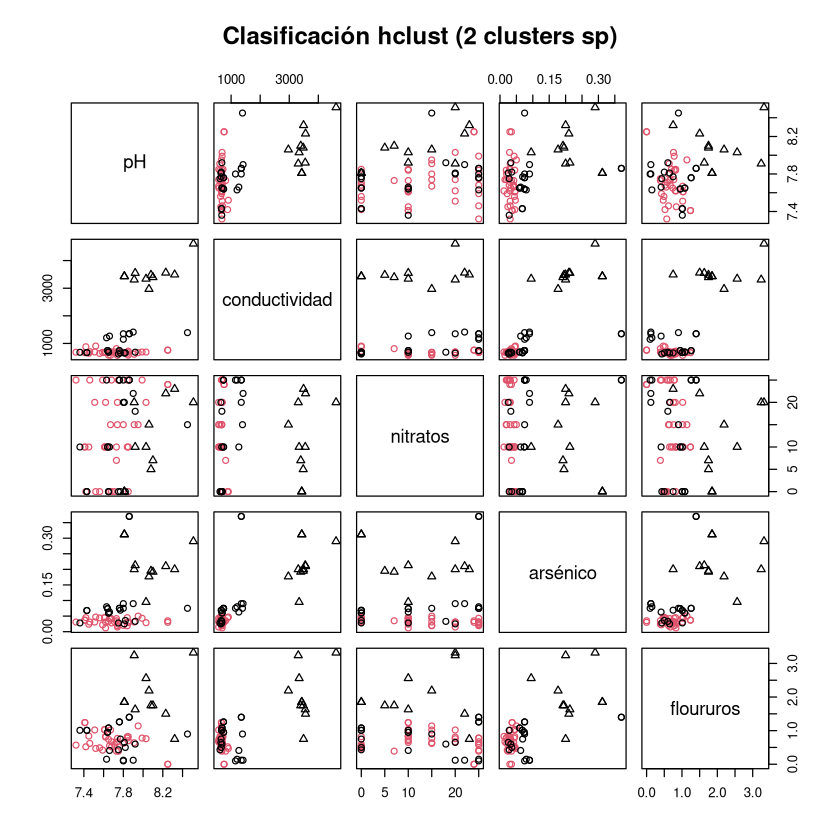

In [37]:
calcular_hclust(parametrosFisicosQuimicosAgua.x, "complete")



Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 68.12 %
           agrupacion2
agrupacion1  2  1
  NoPotable 11 22
  Potable    0 36


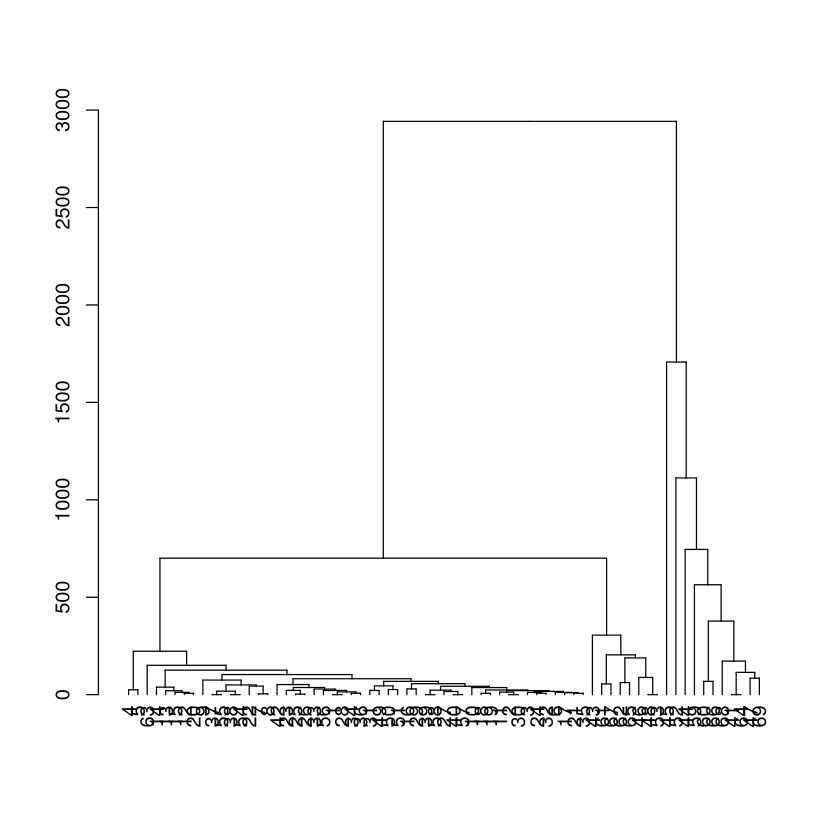

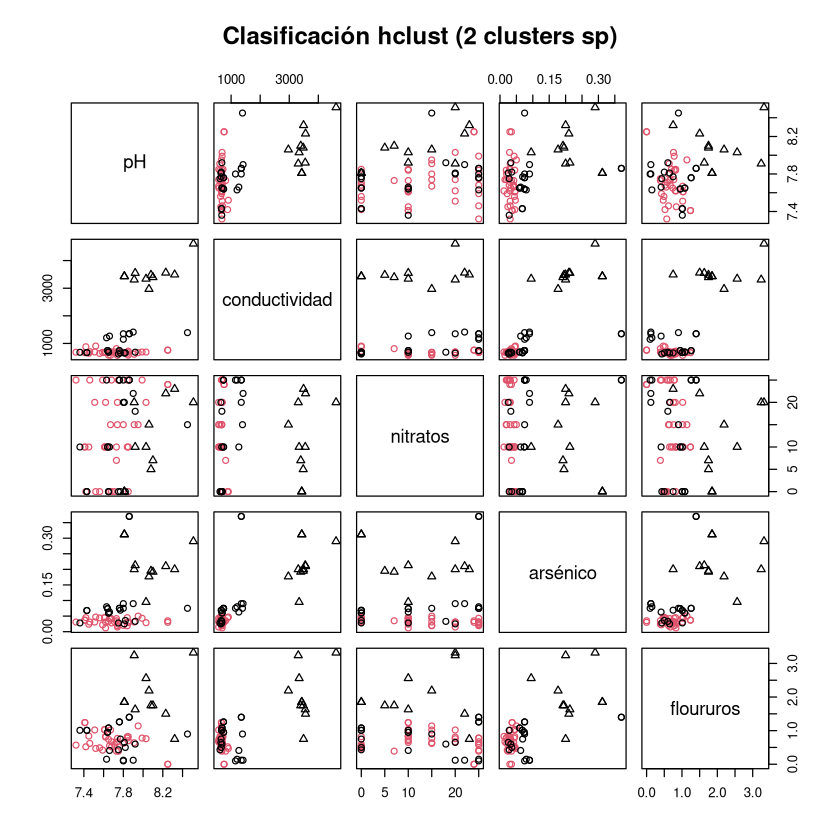

In [38]:
calcular_hclust(parametrosFisicosQuimicosAgua.x, "average")



Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 68.12 %
           agrupacion2
agrupacion1  2  1
  NoPotable 11 22
  Potable    0 36


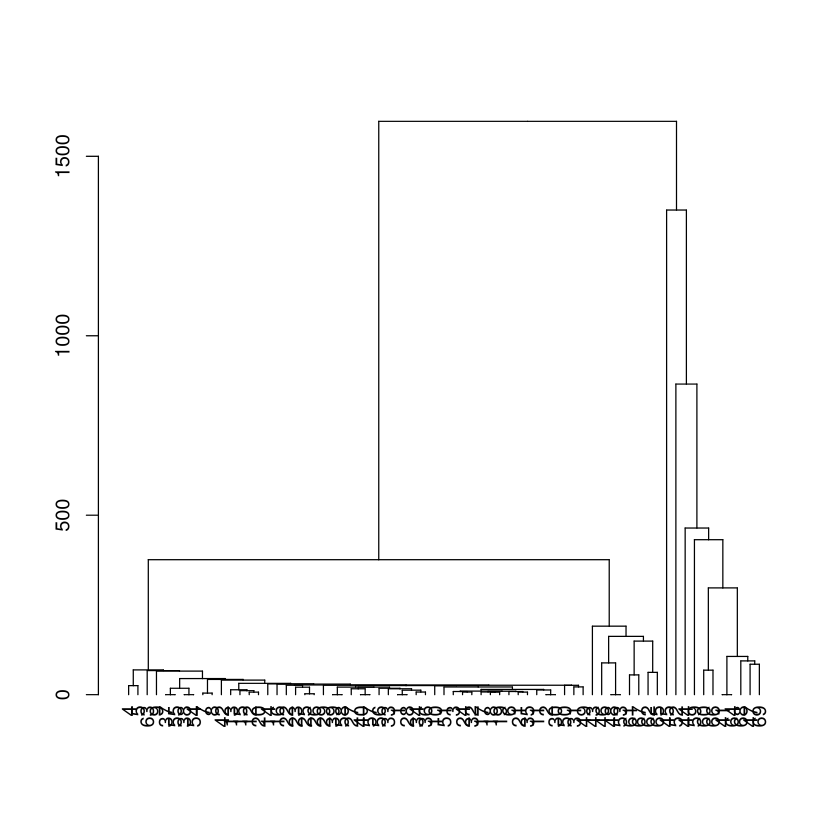

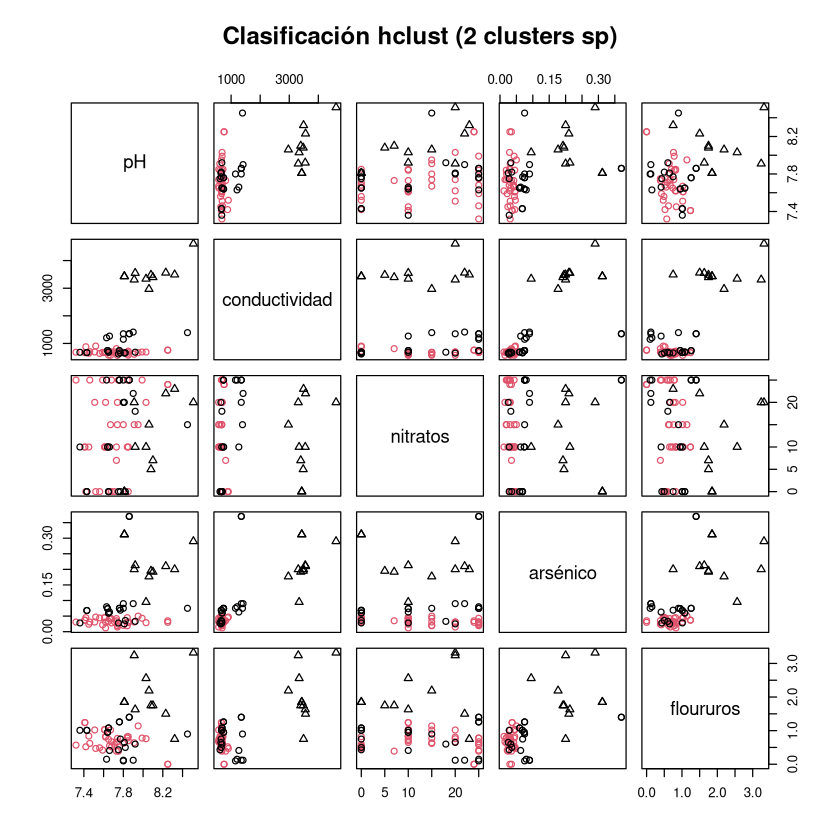

In [39]:
calcular_hclust(parametrosFisicosQuimicosAgua.x, "single")


Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 53.62 %
           agrupacion2
agrupacion1  2  1
  NoPotable  1 32
  Potable    0 36


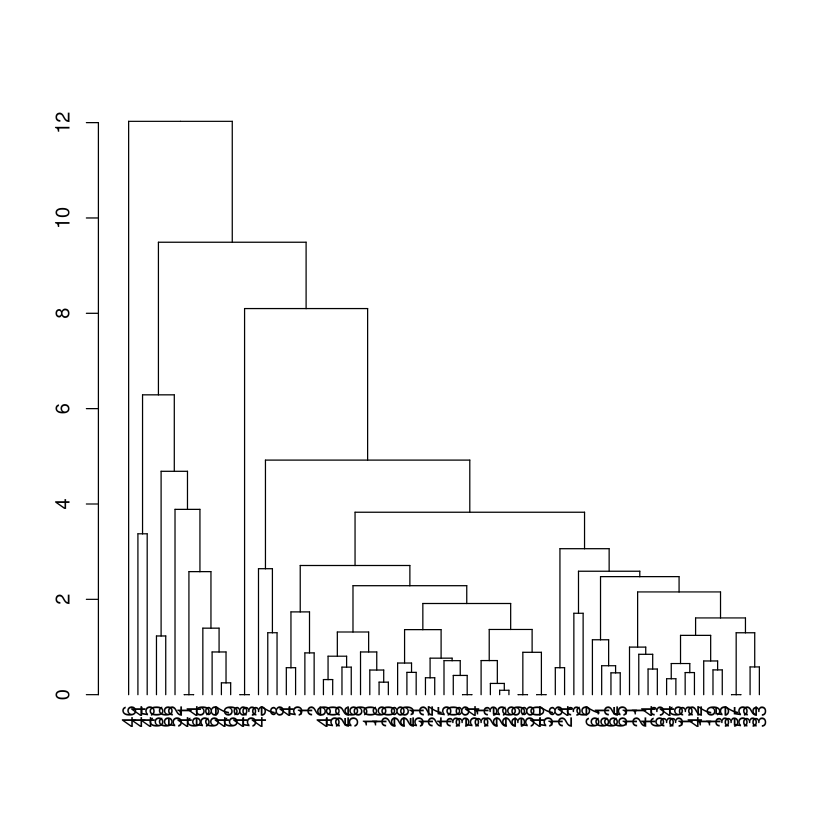

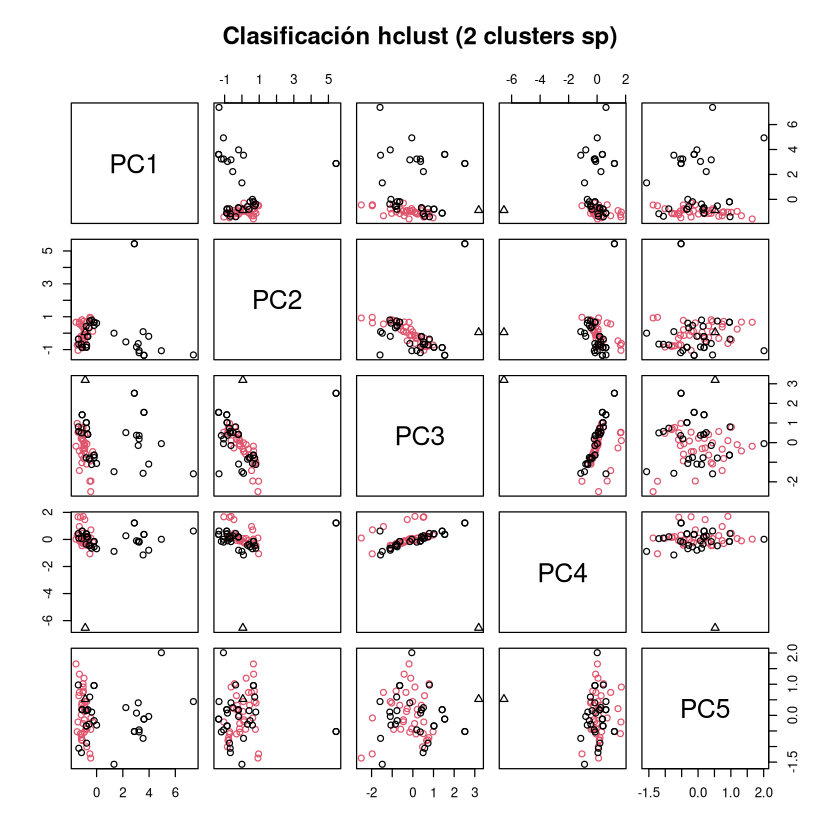

In [40]:
calcular_hclust(parametrosFisicosQuimicosAgua.pca.x, "complete")


Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 53.62 %
           agrupacion2
agrupacion1  2  1
  NoPotable  1 32
  Potable    0 36


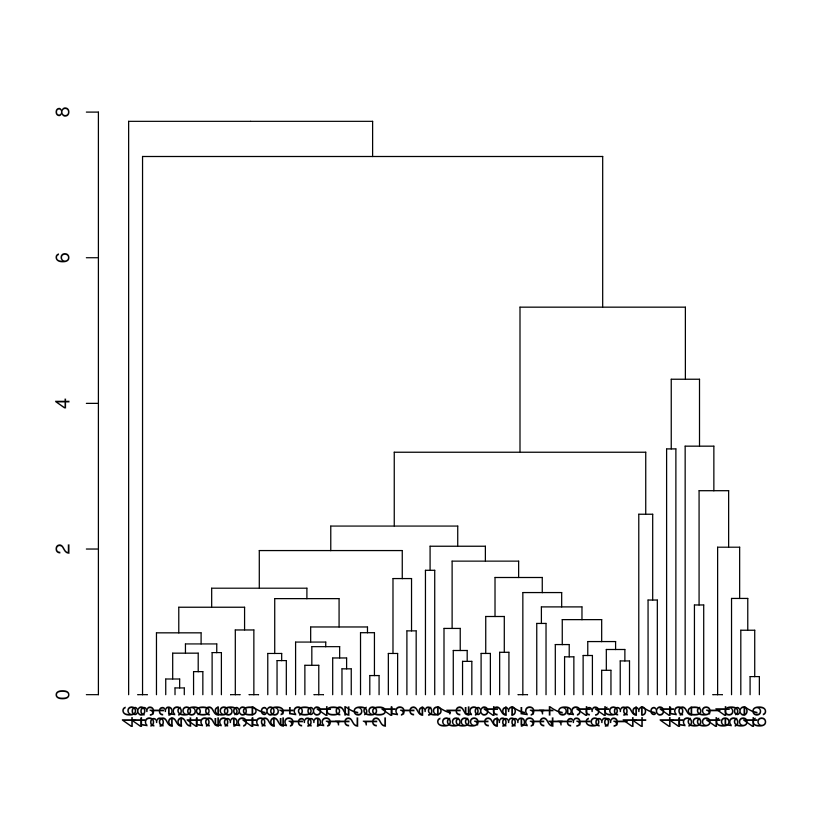

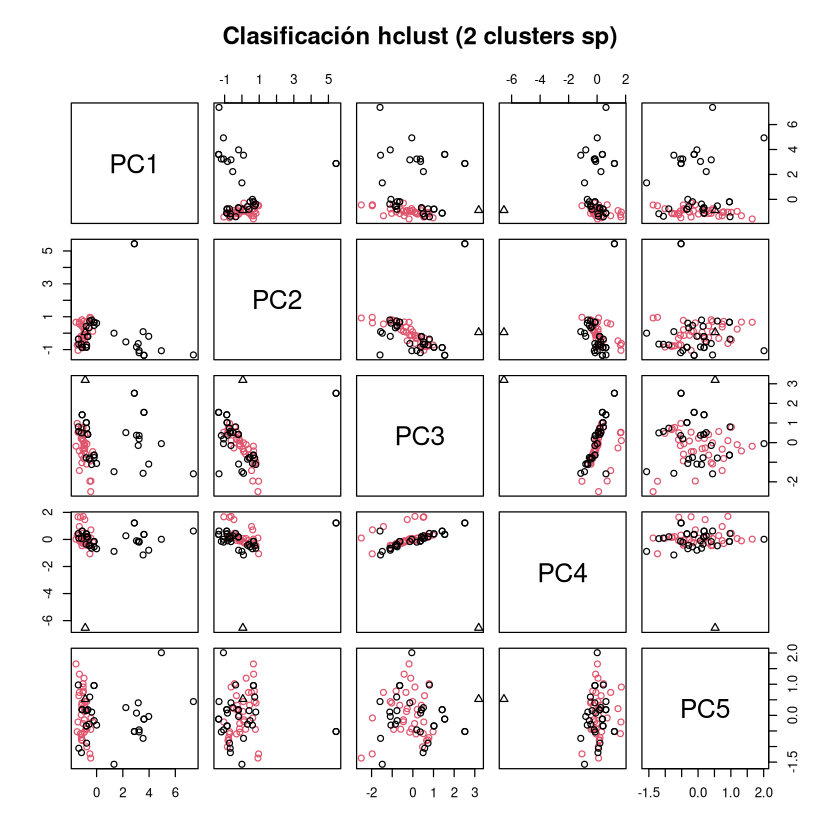

In [41]:
calcular_hclust(parametrosFisicosQuimicosAgua.pca.x, "average")


Mostrando los clustes
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 53.62 %
           agrupacion2
agrupacion1  2  1
  NoPotable  1 32
  Potable    0 36


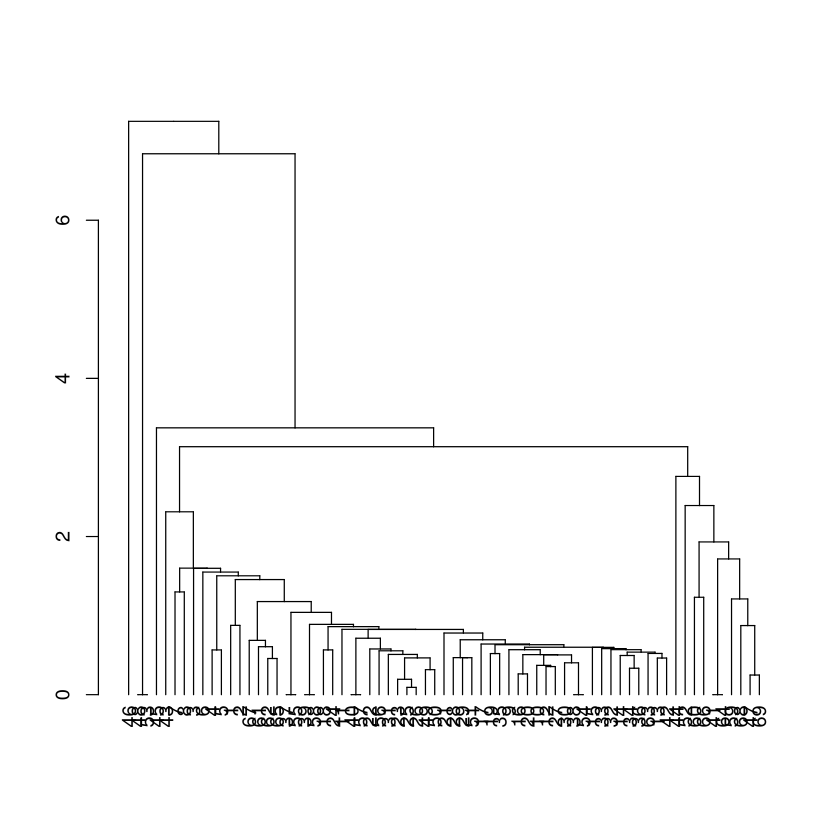

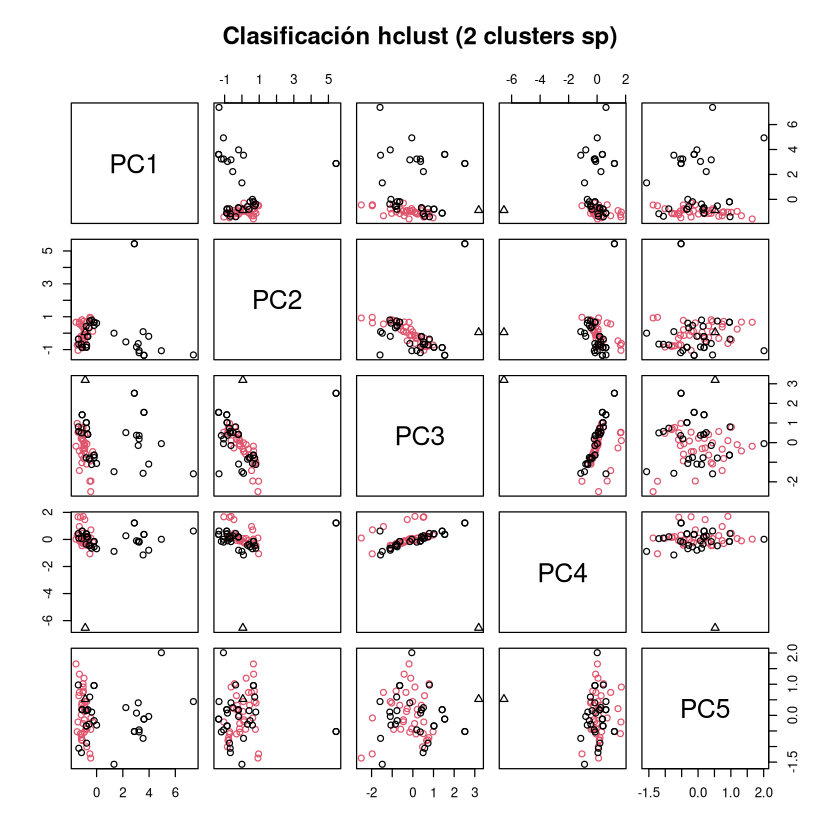

In [42]:
calcular_hclust(parametrosFisicosQuimicosAgua.pca.x, "single")

## Métodos de clasificación

### Folds

In [43]:
library(caret)

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:kernlab’:

    alpha


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



In [44]:
k_folds <- 5

library(caret)
parametrosFisicosQuimicosAgua.folds <- createFolds(t(parametrosFisicosQuimicosAgua.y), k=k_folds)

### Random forest

In [45]:
clasificador.rf <- function(x) {
    # Parámetros
    nroArboles <- 1500
    features <- sort(c(floor(sqrt(dim(parametrosFisicosQuimicosAgua)[2])), 2, 4, 8))

    error <- numeric(length(features))

    for (i in 1:length(features)){
        # Modelo
        parametrosFisicosQuimicosAgua.m.rf <- randomForest(x=x, y=parametrosFisicosQuimicosAgua.y, ntree=nroArboles, mtry=features[i])

        # Calculo del error
        error[i] <- parametrosFisicosQuimicosAgua.m.rf$err.rate[nrow(parametrosFisicosQuimicosAgua.m.rf$err.rate), "OOB"]
    }

    df.error <- data.frame(features, error)

    cat("El error con respecto a las features:\n")
    print(df.error)

    cat("El mínimo es ", min(error), "con ", features[which.min(error)], "features")


    plot(x=features, y=error, type="l", col="blue", lwd=2, xlab="Cantidad de features", ylab="Tasa de error", main="Error en función de la cantidad de features")
    points(features, error, col = "blue", pch = 16)
}

El error con respecto a las features:
  features      error
1        2 0.08695652
2        3 0.07246377
3        4 0.08695652
4        8 0.05797101
El mínimo es  0.05797101 con  8 features

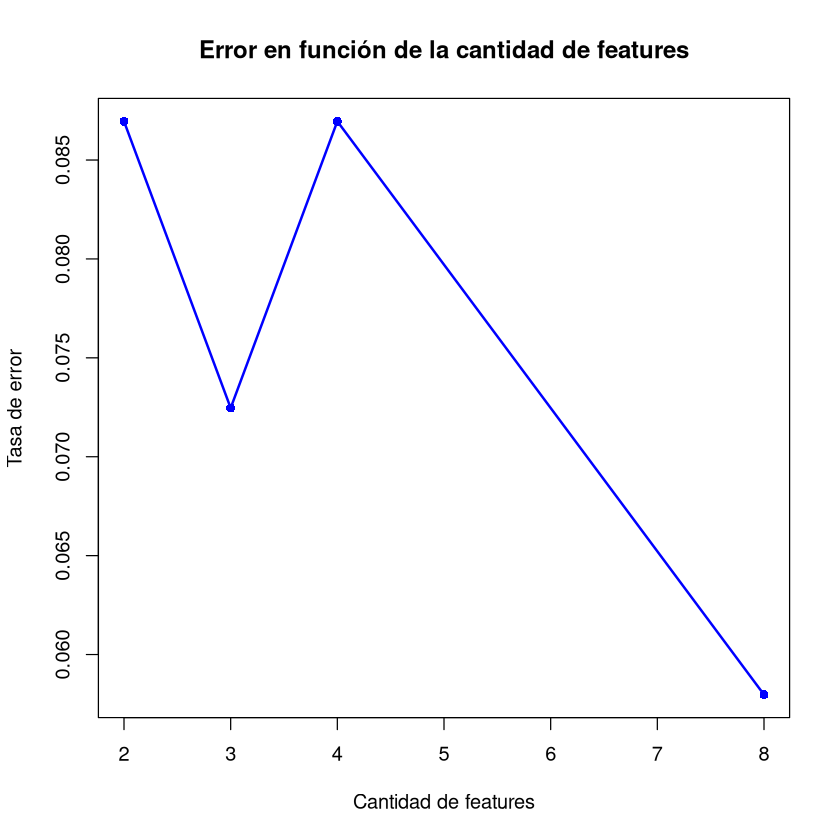

In [46]:
clasificador.rf(parametrosFisicosQuimicosAgua.x)

El error con respecto a las features:
  features     error
1        2 0.1884058
2        3 0.1594203
3        4 0.1594203
4        8 0.1449275
El mínimo es  0.1449275 con  8 features

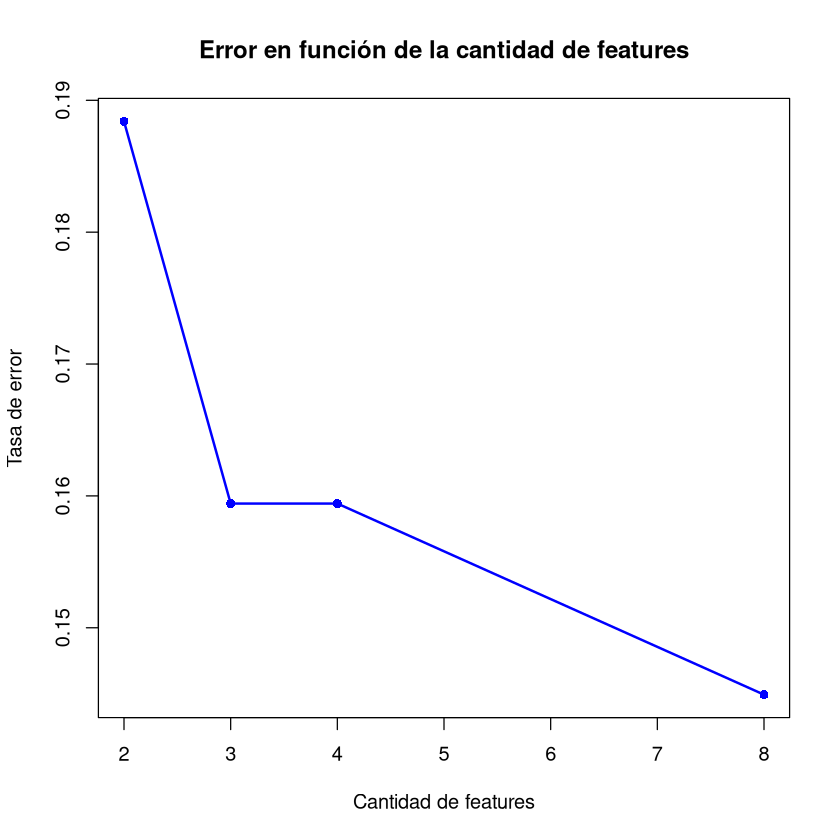

In [47]:
clasificador.rf(parametrosFisicosQuimicosAgua.pca.x)

### Boosting (xgboost)

In [48]:
library(xgboost)

In [79]:
clasificador.boosting <- function(data.x, data.y, k_folds = 5, k_folds.ns = 5, verbosity = 0) {
    data.folds <- createFolds(t(data.y), k=k_folds)

    error <- numeric(k_folds)

    XGB.nrounds=500  #total de arboles/ciclos
    XGB.eta=0.1      #learning rate, similar a redes
    XGB.max.depth.xs = 1:30 #profundidad de los arboles

    if (verbosity > 0) {
        cat("xgboostl\n")
    }

    for (i in 1:k_folds) {
        
        x.train <- as.matrix(data.x[unlist(data.folds[-i]),])
        y.train <- data.y[unlist(data.folds[-i])]

        x.test <- as.matrix(data.x[unlist(data.folds[i]),])
        y.test <- as.integer(data.y[unlist(data.folds[i])]) - 1

        data.folds.ns <- createFolds(t(y.train), k=k_folds.ns)

        error.f <- c()

        if (verbosity > 0) {
            cat("Iteración ", i, "start nested cross-validation\n")
        }

        if (verbosity > 1) {
            cat(k_folds.ns, ": ")
        }

        for (j in 1:k_folds.ns) {
            if (verbosity > 1) {
                cat(j, " ")
            }
            x.train.ns <- as.matrix(x.train[unlist(data.folds.ns[-j]),])
            y.train.ns <- y.train[unlist(data.folds.ns[-j])]

            x.test.ns <- as.matrix(x.train[unlist(data.folds.ns[j]),])
            y.test.ns <- as.integer(y.train[unlist(data.folds.ns[j])]) - 1

            error.d <- numeric(length(XGB.max.depth.xs))

            for (d in 1:length(XGB.max.depth.xs)) {

                XGB.max.depth = XGB.max.depth.xs[d]
                
                m.xgb <- xgboost(data=x.train.ns, label=as.integer(y.train.ns)-1, objective="binary:hinge", nrounds=XGB.nrounds, eta=XGB.eta, max.depth=XGB.max.depth, verbose = 0, nthread=4)

                y.pred <- predict(m.xgb, x.test.ns)
                error.d[d] <- mean(y.pred != y.test.ns)
            }

            error.f <- rbind(error.f, error.d)

        }

        if (verbosity > 1) {
            cat("\n")
        }

        XGB.max.depth <- XGB.max.depth.xs[which.min(colMeans(error.f))]

        m.xgb <- xgboost(data=x.train, label=as.integer(y.train)-1, objective="binary:hinge", nrounds=XGB.nrounds, eta=XGB.eta, max.depth=XGB.max.depth, verbose = 0, nthread=4)

        # Usa el modelo m.xgb para predecir los valores en el conjunto de prueba
        y.pred <- predict(m.xgb, x.test)

        # Calcula la tasa de error (porcentaje de predicciones incorrectas)
        error[i] <- mean(y.pred != y.test)
        if (verbosity > 0) {
            cat("c: ", XGB.max.depth, ", error: ", error[i], "\n")
        }

        flush.console()

    }

    cat("El error es:", mean(error))
    return(mean(error))
}

In [80]:
clasificador.boosting(parametrosFisicosQuimicosAgua.x, parametrosFisicosQuimicosAgua.y)

El error es: 0.1010989

[1] 0.1010989

In [81]:
clasificador.boosting(parametrosFisicosQuimicosAgua.pca.x, parametrosFisicosQuimicosAgua.y)


El error es: 0.1593407

[1] 0.1593407

### Support-vector machines (SVM)

In [89]:

clasificador.svm <- function(data.x, data.y, k_folds = 5, k_folds.ns = 5, verbosity = 0) {
    

    data.folds <- createFolds(t(data.y), k=k_folds)


    error <- numeric(k_folds)

    cs <- c(10000, 100, 10, 1, 0.1, 0.001)

    if (verbosity > 0) {
        cat("svm kernel: lineal\n")
    }

    for (i in 1:k_folds) {
        
        x.train <- as.matrix(data.x[unlist(data.folds[-i]),])
        y.train <- data.y[unlist(data.folds[-i])]

        x.test <- as.matrix(data.x[unlist(data.folds[i]),])
        y.test <- data.y[unlist(data.folds[i])]
        # sv<-svm(x=gausianas[,-3], y = factor(gausianas[,3]), scale = TRUE, type = 'C-classification', kernel = "linear", cost=C)


        data.folds.ns <- createFolds(t(y.train), k=k_folds.ns)

        error.f <- c()

        if (verbosity > 0) {
            cat("Iteración ", i, "start nested cross-validation\n")
        }

        if (verbosity > 1) {
            cat(k_folds.ns, ": ")
        }

        for (j in 1:k_folds.ns) {
            if (verbosity > 1) {
                cat(j, " ")
            }
            x.train.ns <- as.matrix(x.train[unlist(data.folds.ns[-j]),])
            y.train.ns <- y.train[unlist(data.folds.ns[-j])]

            x.test.ns <- as.matrix(x.train[unlist(data.folds.ns[j]),])
            y.test.ns <- y.train[unlist(data.folds.ns[j])]

            error.c <- numeric(length(cs))

            for (c in 1:length(cs)) {
                m.svm <- svm(x=x.train.ns, y = factor(y.train.ns), scale = TRUE, type = 'C-classification', kernel = "linear", cost=cs[c])

                y.pred <- predict(m.svm, x.test.ns)
                error.c[c] <- mean(y.pred != y.test.ns)
            }

            error.f <- rbind(error.f, error.c)

        }

        if (verbosity > 1) {
            cat("\n")
        }

        c <- cs[which.min(colMeans(error.f))]

        m.svm <- svm(x=x.train, y = factor(y.train), scale = TRUE, type = 'C-classification', kernel = "linear", cost=c)

        # Usa el modelo m.xgb para predecir los valores en el conjunto de prueba
        y.pred <- predict(m.svm, x.test)

        # cat(y.pred, "\n", )

        # Calcula la tasa de error (porcentaje de predicciones incorrectas)
        error[i] <- mean(y.pred != y.test)
        if (verbosity > 0) {
            cat("c: ", c, ", error: ", error[i], "\n")
        }

        flush.console()

    }

    cat("El error es:", mean(error))

    return(mean(error))
}

In [83]:

clasificador.svm.poly <- function(data.x, data.y, k_folds = 5, k_folds.ns = 5, verbosity = 0) {
    

    data.folds <- createFolds(t(data.y), k=k_folds)


    error <- numeric(k_folds)


    if (verbosity > 0) {
        cat("svm kernel: polynomial\n")
    }


    for (i in 1:k_folds) {
        
        x.train <- as.matrix(data.x[unlist(data.folds[-i]),])
        y.train <- data.y[unlist(data.folds[-i])]

        x.test <- as.matrix(data.x[unlist(data.folds[i]),])
        y.test <- data.y[unlist(data.folds[i])]

        cs <- c(10000, 1000, 100, 10, 1, 0.1, 0.001)

        grados <- c(2, 3, 4, 5)

        data.folds.ns <- createFolds(t(y.train), k=k_folds.ns)

        error.f <- c()

        if (verbosity > 0) {
            cat("Iteración ", i, "start nested cross-validation\n")
        }

        if (verbosity > 1) {
            cat(k_folds.ns, ": ")
        }

        for (j in 1:k_folds.ns) {
            if (verbosity > 1) {
                cat(j, " ")
            }
            x.train.ns <- as.matrix(x.train[unlist(data.folds.ns[-j]),])
            y.train.ns <- y.train[unlist(data.folds.ns[-j])]

            x.test.ns <- as.matrix(x.train[unlist(data.folds.ns[j]),])
            y.test.ns <- y.train[unlist(data.folds.ns[j])]

            error.c <- c()

            for (c in 1:length(cs)) {
                error.g <- numeric(length(grados))
                for (g in 1:length(grados)) {
                    m.svm <- svm(x=x.train.ns, y = factor(y.train.ns), scale = TRUE, type = 'C-classification', kernel = "polynomial", degree = grados[g], cost=cs[c])

                    y.pred <- predict(m.svm, x.test.ns)
                    error.g[g] <- mean(y.pred != y.test.ns)
                }

                error.c <- cbind(error.c, error.g)
            }

            error.f <- rbind(error.f, error.c)

        }

        if (verbosity > 1) {
            cat("\n")
        }

        error.f.mean <- which.min(colMeans(error.f))

        c <- cs[floor(error.f.mean / length(grados)) + 1]

        g <- grados[error.f.mean %% length(grados)]

        m.svm <- svm(x=x.train, y = factor(y.train), scale = TRUE, type = 'C-classification', kernel = "polynomial", degree = g, cost = c)

        # Usa el modelo m.xgb para predecir los valores en el conjunto de prueba
        y.pred <- predict(m.svm, x.test)
        # Calcula la tasa de error (porcentaje de predicciones incorrectas)
        error[i] <- mean(y.pred != y.test)
        if (verbosity > 0) {
            cat("c: ", c, "g: ", g, ", error: ", error[i], "\n")
        }

        flush.console()

    }

    cat("El error es:", mean(error))
    return(mean(error))
}

In [84]:

clasificador.svm.rd <- function(data.x, data.y, k_folds = 5, k_folds.ns = 5, verbosity = 0) {
    

    data.folds <- createFolds(t(data.y), k=k_folds)


    error <- numeric(k_folds)

    if (verbosity > 0) {
        cat("svm kernel: radial\n")
    }

    for (i in 1:k_folds) {
        
        x.train <- as.matrix(data.x[unlist(data.folds[-i]),])
        y.train <- data.y[unlist(data.folds[-i])]

        x.test <- as.matrix(data.x[unlist(data.folds[i]),])
        y.test <- data.y[unlist(data.folds[i])]

        cs <- c(10000, 1000, 100, 10, 1, 0.1, 0.001)

        gammas <- c(1, 0.1, 0.01, 0.001, 0.0001)

        data.folds.ns <- createFolds(t(y.train), k=k_folds.ns)

        error.f <- c()

        if (verbosity > 0) {
            cat("Iteración ", i, "start nested cross-validation\n")
        }

        if (verbosity > 1) {
            cat(k_folds.ns, ": ")
        }

        for (j in 1:k_folds.ns) {
            if (verbosity > 1) {
                cat(j, " ")
            }
            x.train.ns <- as.matrix(x.train[unlist(data.folds.ns[-j]),])
            y.train.ns <- y.train[unlist(data.folds.ns[-j])]

            x.test.ns <- as.matrix(x.train[unlist(data.folds.ns[j]),])
            y.test.ns <- y.train[unlist(data.folds.ns[j])]

            error.c <- c()

            for (c in 1:length(cs)) {
                error.g <- numeric(length(gammas))
                for (g in 1:length(gammas)) {
                    m.svm <- svm(x=x.train.ns, y = factor(y.train.ns), scale = TRUE, type = 'C-classification', kernel = "radial", gamma = gammas[g], cost=cs[c])

                    y.pred <- predict(m.svm, x.test.ns)
                    error.g[g] <- mean(y.pred != y.test.ns)
                }

                error.c <- cbind(error.c, error.g)
            }

            error.f <- rbind(error.f, error.c)

        }

        if (verbosity > 1) {
            cat("\n")
        }

        error.f.mean <- which.min(colMeans(error.f))

        c <- cs[floor(error.f.mean / length(gammas)) + 1]

        g <- gammas[error.f.mean %% length(gammas)]

        m.svm <- svm(x=x.train, y = factor(y.train), scale = TRUE, type = 'C-classification', kernel = "radial", gamma = g, cost = c)

        # Usa el modelo m.xgb para predecir los valores en el conjunto de prueba
        y.pred <- predict(m.svm, x.test)
        # Calcula la tasa de error (porcentaje de predicciones incorrectas)
        error[i] <- mean(y.pred != y.test)
        if (verbosity > 0) {
            cat("c: ", c, "g: ", g, ", error: ", error[i], "\n")
        }

        flush.console()

    }

    cat("El error es:", mean(error))
    return(mean(error))
}

In [90]:
cat("SVM lineal sobre los datos originales\n")
clasificador.svm(parametrosFisicosQuimicosAgua.x, parametrosFisicosQuimicosAgua.y)

SVM lineal sobre los datos originales


El error es: 0.08791209

[1] 0.08791209

In [91]:
cat("SVM lineal sobre la PCA\n")
clasificador.svm(parametrosFisicosQuimicosAgua.pca.x, parametrosFisicosQuimicosAgua.y)

SVM lineal sobre la PCA
El error es: 0.1464469

[1] 0.1464469

In [92]:
cat("SVM polinómica sobre los datos originales\n")
clasificador.svm.poly(parametrosFisicosQuimicosAgua.x, parametrosFisicosQuimicosAgua.y)

SVM polinómica sobre los datos originales
El error es: 0.2898901

[1] 0.2898901

In [93]:
cat("SVM polinómica sobre la PCA\n")
clasificador.svm.poly(parametrosFisicosQuimicosAgua.pca.x, parametrosFisicosQuimicosAgua.y)

SVM polinómica sobre la PCA


El error es: 0.1301099

[1] 0.1301099

In [94]:
cat("SVM radial sobre los datos originales\n")
clasificador.svm.rd(parametrosFisicosQuimicosAgua.x, parametrosFisicosQuimicosAgua.y)

SVM radial sobre los datos originales
El error es: 0.1423443

[1] 0.1423443

In [95]:
cat("SVM radial sobre la PCA\n")
clasificador.svm.rd(parametrosFisicosQuimicosAgua.pca.x, parametrosFisicosQuimicosAgua.y)

SVM radial sobre la PCA
El error es: 0.1312088

[1] 0.1312088